In [1]:
%load_ext autoreload
%autoreload 2

# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.  
And it contains below features:
1. Transforms for dictionary format data.
2. Define a new transform according to MONAI transform API.
3. Load Nifti image with metadata, load a list of images and stack them.
4. Randomly adjust intensity for data augmentation.
5. Cache IO and transforms to accelerate training and validation.
6. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
7. Deterministic training for reproducibility.

The Brain tumor dataset can be downloaded from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right). (Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))  
![image](./images/brats_tasks.png)
The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
2. the tumor core (red) visible in T2 (Fig.B).
3. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
4. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import \
    MapTransform, Compose, LoadNiftid, AsChannelFirstd, Spacingd, Orientationd, \
    RandSpatialCropd, RandFlipd, NormalizeIntensityd, RandScaleIntensityd, \
    RandShiftIntensityd, CenterSpatialCropd, ToTensord, ConcatItemsd, AddChanneld, \
    Lambdad, DeleteItemsd
from monai.data import DataLoader
from monai.apps import DecathlonDataset
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism

import dataset

## Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels
Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Annotations comprise the GD-enhancing tumor (ET — label 4),
    the peritumoral edema (ED — label 2),
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    
    
    
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WC (Whole tumor)
    and ET (Enhancing tumor).

    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = list()
            # ch 0 - NCR/NET - label 1
            result.append(d[key] == 1)
            # ch 1 - ED - label 2
            result.append(d[key] == 2)
            # ch 2 - ET - label 4
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

## Setup transforms for training and validation

In [5]:
train_transform = Compose([
    # load 4 Nifti images and stack them together
    LoadNiftid(keys=['t1', 't2', 'flair', 't1ce', 'seg']),
    AddChanneld(keys=['t1', 't2', 'flair', 't1ce']),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
    Spacingd(keys=['t1', 't2', 'flair', 't1ce', 'seg'], pixdim=(1.5, 1.5, 2.),
             mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    Orientationd(keys=['t1', 't2', 'flair', 't1ce', 'seg'], axcodes='RAS'),
    ConcatItemsd(keys=['t1', 't2', 'flair', 't1ce'], name='image'),
    DeleteItemsd(keys=['t1', 't2', 'flair', 't1ce']),
    RandSpatialCropd(keys=['image', 'seg'], roi_size=[128, 128, 64], random_size=False),
    RandFlipd(keys=['image', 'seg'], prob=0.5, spatial_axis=0),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    RandScaleIntensityd(keys=['image'], factors=0.1, prob=0.5),
    RandShiftIntensityd(keys=['image'], offsets=0.1, prob=0.5),
    ToTensord(keys=['image', 'seg'])
])
val_transform = Compose([
    LoadNiftid(keys=['t1', 't2', 'flair', 't1ce', 'seg']),
    AddChanneld(keys=['t1', 't2', 'flair', 't1ce']),
    ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
    Spacingd(keys=['t1', 't2', 'flair', 't1ce', 'seg'], pixdim=(1.5, 1.5, 2.),
             mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    Orientationd(keys=['t1', 't2', 'flair', 't1ce', 'seg'], axcodes='RAS'),
    ConcatItemsd(keys=['t1', 't2', 'flair', 't1ce'], name='image'),
    DeleteItemsd(keys=['t1', 't2', 'flair', 't1ce']),
    CenterSpatialCropd(keys=['image', 'seg'], roi_size=[128, 128, 64]),
    NormalizeIntensityd(keys=['image'], nonzero=True, channel_wise=True),
    ToTensord(keys=['image', 'seg'])
])

## Quickly load data with DecathlonDataset
Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, so we set `cache_num=100` to cache 100 items for training and use the defaut args to cache all the items for validation.

In [6]:
train_ds = dataset.BraTSDataset(root_dir='./data/MICCAI_BraTS2020_TrainingData_train/',
                                transform=train_transform, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

281/281 Load and cache transformed data:  [==============================]


In [7]:
val_ds = dataset.BraTSDataset(root_dir='./data/MICCAI_BraTS2020_TrainingData_dev/',
                              transform=val_transform, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

88/88 Load and cache transformed data:  [==============================]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


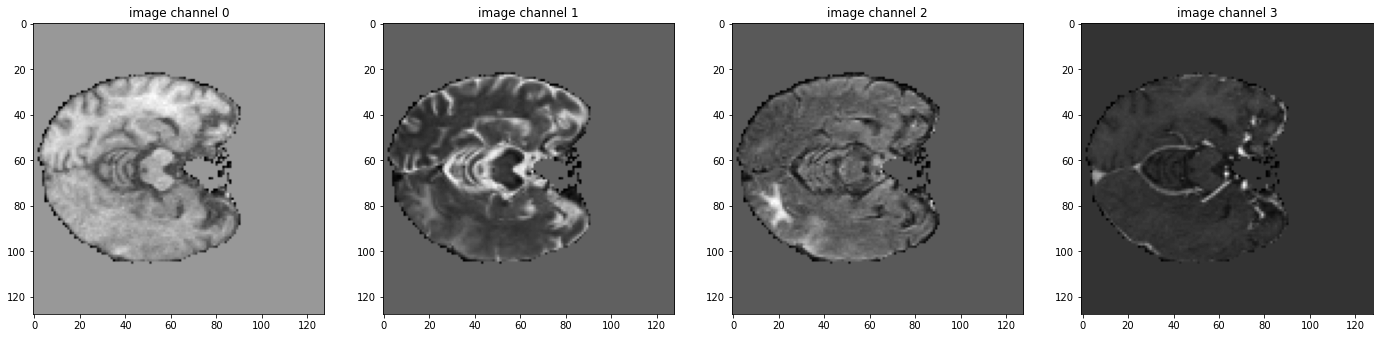

label shape: torch.Size([3, 128, 128, 64])


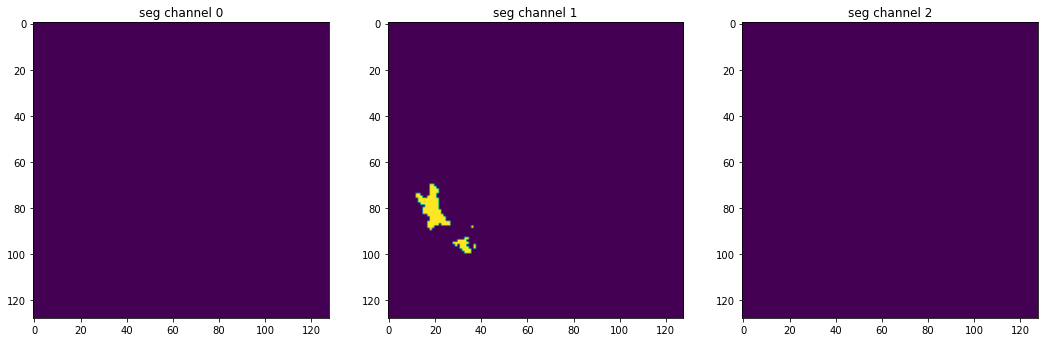

In [8]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[9]['image'].shape}")
plt.figure('image', (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {str(i)}")
    plt.imshow(val_ds[9]['image'][i, :, :, 20].detach().cpu(), cmap='gray')
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[9]['seg'].shape}")
plt.figure('seg', (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"seg channel {str(i)}")
    plt.imshow(val_ds[9]['seg'][i, :, :, 20].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [9]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device('cuda:0')
model = UNet(dimensions=3, in_channels=4, out_channels=3, channels=(16, 32, 64, 128, 256),
             strides=(2, 2, 2, 2), num_res_units=2).to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True)

## Execute a typical PyTorch training process

In [10]:
epoch_num = 180
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
metric_values_tc = list()
metric_values_wt = list()
metric_values_et = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['seg'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, sigmoid=True, reduction='mean')
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.
            metric_count = metric_count_tc = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data['image'].to(device), val_data['seg'].to(device)
                val_outputs = model(val_inputs)
                # compute overall mean dice
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = dice_metric.not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc = dice_metric(y_pred=val_outputs[:, 0 : 1], y=val_labels[:, 0 : 1])
                not_nans = dice_metric.not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt = dice_metric(y_pred=val_outputs[:, 1 : 2], y=val_labels[:, 1 : 2])
                not_nans = dice_metric.not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et = dice_metric(y_pred=val_outputs[:, 2 : 3], y=val_labels[:, 2 : 3])
                not_nans = dice_metric.not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                  f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/180
1/140, train_loss: 0.9625
2/140, train_loss: 0.9741
3/140, train_loss: 0.9867
4/140, train_loss: 0.9756
5/140, train_loss: 0.9849
6/140, train_loss: 0.9519
7/140, train_loss: 0.9782
8/140, train_loss: 0.9823
9/140, train_loss: 0.9631
10/140, train_loss: 0.9612
11/140, train_loss: 0.9697
12/140, train_loss: 0.9661
13/140, train_loss: 0.9788
14/140, train_loss: 0.9505
15/140, train_loss: 0.9774
16/140, train_loss: 0.9747
17/140, train_loss: 0.9834
18/140, train_loss: 0.9453
19/140, train_loss: 0.9641
20/140, train_loss: 0.9500
21/140, train_loss: 0.9529
22/140, train_loss: 0.9480
23/140, train_loss: 0.9389
24/140, train_loss: 0.9395
25/140, train_loss: 0.9251
26/140, train_loss: 0.9435
27/140, train_loss: 0.9473
28/140, train_loss: 0.9473
29/140, train_loss: 0.9686
30/140, train_loss: 0.9610
31/140, train_loss: 0.9616
32/140, train_loss: 0.9602
33/140, train_loss: 0.9411
34/140, train_loss: 0.9746
35/140, train_loss: 0.9544
36/140, train_loss: 0.9724
37/140, train_

11/140, train_loss: 0.9283
12/140, train_loss: 0.9671
13/140, train_loss: 0.9658
14/140, train_loss: 0.9092
15/140, train_loss: 0.9541
16/140, train_loss: 0.9791
17/140, train_loss: 0.9880
18/140, train_loss: 0.9485
19/140, train_loss: 0.9752
20/140, train_loss: 0.9714
21/140, train_loss: 0.9812
22/140, train_loss: 0.9506
23/140, train_loss: 0.9892
24/140, train_loss: 0.9703
25/140, train_loss: 0.9514
26/140, train_loss: 0.9852
27/140, train_loss: 0.9580
28/140, train_loss: 0.9543
29/140, train_loss: 0.9341
30/140, train_loss: 0.9810
31/140, train_loss: 0.9611
32/140, train_loss: 0.9358
33/140, train_loss: 0.9498
34/140, train_loss: 0.9588
35/140, train_loss: 0.9694
36/140, train_loss: 0.9471
37/140, train_loss: 0.9404
38/140, train_loss: 0.9574
39/140, train_loss: 0.9392
40/140, train_loss: 0.9506
41/140, train_loss: 0.9562
42/140, train_loss: 0.9498
43/140, train_loss: 0.9539
44/140, train_loss: 0.9584
45/140, train_loss: 0.9743
46/140, train_loss: 0.9840
47/140, train_loss: 0.9229
4

21/140, train_loss: 0.9284
22/140, train_loss: 0.9321
23/140, train_loss: 0.9410
24/140, train_loss: 0.9721
25/140, train_loss: 0.9563
26/140, train_loss: 0.9354
27/140, train_loss: 0.9749
28/140, train_loss: 0.9350
29/140, train_loss: 0.9661
30/140, train_loss: 0.9294
31/140, train_loss: 0.9454
32/140, train_loss: 0.8675
33/140, train_loss: 0.9834
34/140, train_loss: 0.9713
35/140, train_loss: 0.9556
36/140, train_loss: 0.9311
37/140, train_loss: 0.9267
38/140, train_loss: 0.9221
39/140, train_loss: 0.9584
40/140, train_loss: 0.9301
41/140, train_loss: 0.9430
42/140, train_loss: 0.9607
43/140, train_loss: 0.9394
44/140, train_loss: 0.9268
45/140, train_loss: 0.9231
46/140, train_loss: 0.9671
47/140, train_loss: 0.9457
48/140, train_loss: 0.9600
49/140, train_loss: 0.9217
50/140, train_loss: 0.9775
51/140, train_loss: 0.9302
52/140, train_loss: 0.9755
53/140, train_loss: 0.9048
54/140, train_loss: 0.9319
55/140, train_loss: 0.9446
56/140, train_loss: 0.9843
57/140, train_loss: 0.9483
5

31/140, train_loss: 0.9527
32/140, train_loss: 0.9325
33/140, train_loss: 0.9176
34/140, train_loss: 0.8897
35/140, train_loss: 0.9085
36/140, train_loss: 0.9100
37/140, train_loss: 0.9258
38/140, train_loss: 0.9102
39/140, train_loss: 0.8898
40/140, train_loss: 0.9346
41/140, train_loss: 0.9687
42/140, train_loss: 0.9502
43/140, train_loss: 0.9412
44/140, train_loss: 0.9473
45/140, train_loss: 0.9547
46/140, train_loss: 0.9205
47/140, train_loss: 0.8956
48/140, train_loss: 0.8930
49/140, train_loss: 0.9491
50/140, train_loss: 0.9231
51/140, train_loss: 0.8971
52/140, train_loss: 0.9178
53/140, train_loss: 0.9713
54/140, train_loss: 0.9452
55/140, train_loss: 0.9452
56/140, train_loss: 0.9654
57/140, train_loss: 0.9415
58/140, train_loss: 0.9472
59/140, train_loss: 0.9261
60/140, train_loss: 0.9701
61/140, train_loss: 0.9637
62/140, train_loss: 0.9594
63/140, train_loss: 0.9458
64/140, train_loss: 0.9027
65/140, train_loss: 0.9300
66/140, train_loss: 0.9318
67/140, train_loss: 0.9687
6

41/140, train_loss: 0.9315
42/140, train_loss: 0.9332
43/140, train_loss: 0.8895
44/140, train_loss: 0.9294
45/140, train_loss: 0.9875
46/140, train_loss: 0.9604
47/140, train_loss: 0.9419
48/140, train_loss: 0.8507
49/140, train_loss: 0.8522
50/140, train_loss: 0.9330
51/140, train_loss: 0.9382
52/140, train_loss: 0.8843
53/140, train_loss: 0.9272
54/140, train_loss: 0.8913
55/140, train_loss: 0.8875
56/140, train_loss: 0.8923
57/140, train_loss: 0.8738
58/140, train_loss: 0.9409
59/140, train_loss: 0.9735
60/140, train_loss: 0.8439
61/140, train_loss: 0.9697
62/140, train_loss: 0.9653
63/140, train_loss: 0.9119
64/140, train_loss: 0.9554
65/140, train_loss: 0.9225
66/140, train_loss: 0.9295
67/140, train_loss: 0.9325
68/140, train_loss: 0.9216
69/140, train_loss: 0.9351
70/140, train_loss: 0.9314
71/140, train_loss: 0.8442
72/140, train_loss: 0.8580
73/140, train_loss: 0.9670
74/140, train_loss: 0.9461
75/140, train_loss: 0.9100
76/140, train_loss: 0.9494
77/140, train_loss: 0.9178
7

51/140, train_loss: 0.9145
52/140, train_loss: 0.8868
53/140, train_loss: 0.9455
54/140, train_loss: 0.9293
55/140, train_loss: 0.8869
56/140, train_loss: 0.8890
57/140, train_loss: 0.9491
58/140, train_loss: 0.8960
59/140, train_loss: 0.9252
60/140, train_loss: 0.9161
61/140, train_loss: 0.8995
62/140, train_loss: 0.9152
63/140, train_loss: 0.8311
64/140, train_loss: 0.9454
65/140, train_loss: 0.9042
66/140, train_loss: 0.9500
67/140, train_loss: 0.9037
68/140, train_loss: 0.8750
69/140, train_loss: 0.9586
70/140, train_loss: 0.8029
71/140, train_loss: 0.8679
72/140, train_loss: 0.9273
73/140, train_loss: 0.9435
74/140, train_loss: 0.8358
75/140, train_loss: 0.8695
76/140, train_loss: 0.9539
77/140, train_loss: 0.8892
78/140, train_loss: 0.8344
79/140, train_loss: 0.8731
80/140, train_loss: 0.9467
81/140, train_loss: 0.8675
82/140, train_loss: 0.8648
83/140, train_loss: 0.9565
84/140, train_loss: 0.8409
85/140, train_loss: 0.8665
86/140, train_loss: 0.8873
87/140, train_loss: 0.9051
8

61/140, train_loss: 0.8087
62/140, train_loss: 0.9509
63/140, train_loss: 0.8055
64/140, train_loss: 0.8448
65/140, train_loss: 0.8711
66/140, train_loss: 0.9042
67/140, train_loss: 0.9677
68/140, train_loss: 0.8794
69/140, train_loss: 0.8769
70/140, train_loss: 0.8820
71/140, train_loss: 0.9112
72/140, train_loss: 0.9140
73/140, train_loss: 0.9070
74/140, train_loss: 0.8101
75/140, train_loss: 0.7891
76/140, train_loss: 0.9241
77/140, train_loss: 0.9380
78/140, train_loss: 0.8149
79/140, train_loss: 0.7776
80/140, train_loss: 0.8758
81/140, train_loss: 0.8825
82/140, train_loss: 0.8712
83/140, train_loss: 0.8700
84/140, train_loss: 0.9195
85/140, train_loss: 0.8624
86/140, train_loss: 0.8687
87/140, train_loss: 0.8527
88/140, train_loss: 0.9176
89/140, train_loss: 0.8120
90/140, train_loss: 0.7892
91/140, train_loss: 0.8383
92/140, train_loss: 0.9216
93/140, train_loss: 0.8356
94/140, train_loss: 0.8412
95/140, train_loss: 0.7925
96/140, train_loss: 0.8528
97/140, train_loss: 0.8030
9

71/140, train_loss: 0.7956
72/140, train_loss: 0.8802
73/140, train_loss: 0.7692
74/140, train_loss: 0.8240
75/140, train_loss: 0.8517
76/140, train_loss: 0.8783
77/140, train_loss: 0.7881
78/140, train_loss: 0.8926
79/140, train_loss: 0.8723
80/140, train_loss: 0.8531
81/140, train_loss: 0.7919
82/140, train_loss: 0.8132
83/140, train_loss: 0.8662
84/140, train_loss: 0.7482
85/140, train_loss: 0.7959
86/140, train_loss: 0.7501
87/140, train_loss: 0.8989
88/140, train_loss: 0.7744
89/140, train_loss: 0.8643
90/140, train_loss: 0.8436
91/140, train_loss: 0.7942
92/140, train_loss: 0.8681
93/140, train_loss: 0.8308
94/140, train_loss: 0.8119
95/140, train_loss: 0.8990
96/140, train_loss: 0.7441
97/140, train_loss: 0.8634
98/140, train_loss: 0.8319
99/140, train_loss: 0.8252
100/140, train_loss: 0.8404
101/140, train_loss: 0.8393
102/140, train_loss: 0.8549
103/140, train_loss: 0.8534
104/140, train_loss: 0.7978
105/140, train_loss: 0.8607
106/140, train_loss: 0.8204
107/140, train_loss: 

81/140, train_loss: 0.7870
82/140, train_loss: 0.8329
83/140, train_loss: 0.9657
84/140, train_loss: 0.8910
85/140, train_loss: 0.8297
86/140, train_loss: 0.7463
87/140, train_loss: 0.7453
88/140, train_loss: 0.9439
89/140, train_loss: 0.9032
90/140, train_loss: 0.9162
91/140, train_loss: 0.8696
92/140, train_loss: 0.8484
93/140, train_loss: 0.7932
94/140, train_loss: 0.7938
95/140, train_loss: 0.7635
96/140, train_loss: 0.9145
97/140, train_loss: 0.7326
98/140, train_loss: 0.9033
99/140, train_loss: 0.9188
100/140, train_loss: 0.7697
101/140, train_loss: 0.8054
102/140, train_loss: 0.7664
103/140, train_loss: 0.8619
104/140, train_loss: 0.8306
105/140, train_loss: 0.8748
106/140, train_loss: 0.8886
107/140, train_loss: 0.9318
108/140, train_loss: 0.8645
109/140, train_loss: 0.7746
110/140, train_loss: 0.8630
111/140, train_loss: 0.9383
112/140, train_loss: 0.8425
113/140, train_loss: 0.9239
114/140, train_loss: 0.9287
115/140, train_loss: 0.8548
116/140, train_loss: 0.8613
117/140, tr

91/140, train_loss: 0.6711
92/140, train_loss: 0.6437
93/140, train_loss: 0.6664
94/140, train_loss: 0.7619
95/140, train_loss: 0.9095
96/140, train_loss: 0.8439
97/140, train_loss: 0.8389
98/140, train_loss: 0.6871
99/140, train_loss: 0.8936
100/140, train_loss: 0.7893
101/140, train_loss: 0.7670
102/140, train_loss: 0.9730
103/140, train_loss: 0.7772
104/140, train_loss: 0.8178
105/140, train_loss: 0.8163
106/140, train_loss: 0.8062
107/140, train_loss: 0.8447
108/140, train_loss: 0.6883
109/140, train_loss: 0.6979
110/140, train_loss: 0.9254
111/140, train_loss: 0.8092
112/140, train_loss: 0.8242
113/140, train_loss: 0.8472
114/140, train_loss: 0.7081
115/140, train_loss: 0.7119
116/140, train_loss: 0.8373
117/140, train_loss: 0.8781
118/140, train_loss: 0.9109
119/140, train_loss: 0.8520
120/140, train_loss: 0.7794
121/140, train_loss: 0.7391
122/140, train_loss: 0.8541
123/140, train_loss: 0.7441
124/140, train_loss: 0.8174
125/140, train_loss: 0.6373
126/140, train_loss: 0.7650
1

101/140, train_loss: 0.8916
102/140, train_loss: 0.7188
103/140, train_loss: 0.9085
104/140, train_loss: 0.7586
105/140, train_loss: 0.7596
106/140, train_loss: 0.7198
107/140, train_loss: 0.8172
108/140, train_loss: 0.7909
109/140, train_loss: 0.7175
110/140, train_loss: 0.8622
111/140, train_loss: 0.6368
112/140, train_loss: 0.8738
113/140, train_loss: 0.7592
114/140, train_loss: 0.7706
115/140, train_loss: 0.6513
116/140, train_loss: 0.7503
117/140, train_loss: 0.6765
118/140, train_loss: 0.7979
119/140, train_loss: 0.8090
120/140, train_loss: 0.8218
121/140, train_loss: 0.9397
122/140, train_loss: 0.7087
123/140, train_loss: 0.8221
124/140, train_loss: 0.8183
125/140, train_loss: 0.8420
126/140, train_loss: 0.7445
127/140, train_loss: 0.8443
128/140, train_loss: 0.9214
129/140, train_loss: 0.8364
130/140, train_loss: 0.7781
131/140, train_loss: 0.6952
132/140, train_loss: 0.6718
133/140, train_loss: 0.8400
134/140, train_loss: 0.7004
135/140, train_loss: 0.7188
136/140, train_loss:

111/140, train_loss: 0.6687
112/140, train_loss: 0.8389
113/140, train_loss: 0.9239
114/140, train_loss: 0.7297
115/140, train_loss: 0.8310
116/140, train_loss: 0.9070
117/140, train_loss: 0.8705
118/140, train_loss: 0.8600
119/140, train_loss: 0.8218
120/140, train_loss: 0.8092
121/140, train_loss: 0.8161
122/140, train_loss: 0.7295
123/140, train_loss: 0.7214
124/140, train_loss: 0.7840
125/140, train_loss: 0.8450
126/140, train_loss: 0.7636
127/140, train_loss: 0.8324
128/140, train_loss: 0.7182
129/140, train_loss: 0.7006
130/140, train_loss: 0.6955
131/140, train_loss: 0.8645
132/140, train_loss: 0.8017
133/140, train_loss: 0.7589
134/140, train_loss: 0.6387
135/140, train_loss: 0.6915
136/140, train_loss: 0.7779
137/140, train_loss: 0.8961
138/140, train_loss: 0.7967
139/140, train_loss: 0.9277
140/140, train_loss: 0.7573
141/140, train_loss: 0.6137
epoch 23 average loss: 0.7738
----------
epoch 24/180
1/140, train_loss: 0.7905
2/140, train_loss: 0.7350
3/140, train_loss: 0.8199


122/140, train_loss: 0.6966
123/140, train_loss: 0.8332
124/140, train_loss: 0.7847
125/140, train_loss: 0.7151
126/140, train_loss: 0.6256
127/140, train_loss: 0.7258
128/140, train_loss: 0.9454
129/140, train_loss: 0.8644
130/140, train_loss: 0.8487
131/140, train_loss: 0.7852
132/140, train_loss: 0.7587
133/140, train_loss: 0.6603
134/140, train_loss: 0.7258
135/140, train_loss: 0.8376
136/140, train_loss: 0.8556
137/140, train_loss: 0.6999
138/140, train_loss: 0.7058
139/140, train_loss: 0.7640
140/140, train_loss: 0.8334
141/140, train_loss: 0.8183
epoch 25 average loss: 0.7634
----------
epoch 26/180
1/140, train_loss: 0.6610
2/140, train_loss: 0.9582
3/140, train_loss: 0.7035
4/140, train_loss: 0.7189
5/140, train_loss: 0.7966
6/140, train_loss: 0.6887
7/140, train_loss: 0.6410
8/140, train_loss: 0.9193
9/140, train_loss: 0.7502
10/140, train_loss: 0.7009
11/140, train_loss: 0.7746
12/140, train_loss: 0.8599
13/140, train_loss: 0.7190
14/140, train_loss: 0.9209
15/140, train_los

133/140, train_loss: 0.8349
134/140, train_loss: 0.8415
135/140, train_loss: 0.7184
136/140, train_loss: 0.6121
137/140, train_loss: 0.8342
138/140, train_loss: 0.7617
139/140, train_loss: 0.7338
140/140, train_loss: 0.7093
141/140, train_loss: 0.6443
epoch 27 average loss: 0.7509
----------
epoch 28/180
1/140, train_loss: 0.6795
2/140, train_loss: 0.8247
3/140, train_loss: 0.7155
4/140, train_loss: 0.6901
5/140, train_loss: 0.8811
6/140, train_loss: 0.7506
7/140, train_loss: 0.7280
8/140, train_loss: 0.8792
9/140, train_loss: 0.7356
10/140, train_loss: 0.7116
11/140, train_loss: 0.7677
12/140, train_loss: 0.7803
13/140, train_loss: 0.7250
14/140, train_loss: 0.7518
15/140, train_loss: 0.7748
16/140, train_loss: 0.8192
17/140, train_loss: 0.8123
18/140, train_loss: 0.7743
19/140, train_loss: 0.7466
20/140, train_loss: 0.8012
21/140, train_loss: 0.7327
22/140, train_loss: 0.7487
23/140, train_loss: 0.7588
24/140, train_loss: 0.7484
25/140, train_loss: 0.7859
26/140, train_loss: 0.7912
2

1/140, train_loss: 0.8522
2/140, train_loss: 0.8405
3/140, train_loss: 0.6699
4/140, train_loss: 0.6105
5/140, train_loss: 0.6558
6/140, train_loss: 0.7369
7/140, train_loss: 0.7236
8/140, train_loss: 0.7063
9/140, train_loss: 0.7430
10/140, train_loss: 0.7786
11/140, train_loss: 0.6074
12/140, train_loss: 0.8118
13/140, train_loss: 0.7266
14/140, train_loss: 0.7147
15/140, train_loss: 0.7167
16/140, train_loss: 0.6228
17/140, train_loss: 0.8833
18/140, train_loss: 0.7332
19/140, train_loss: 0.6737
20/140, train_loss: 0.8680
21/140, train_loss: 0.7591
22/140, train_loss: 0.6508
23/140, train_loss: 0.8115
24/140, train_loss: 0.8251
25/140, train_loss: 0.7229
26/140, train_loss: 0.8243
27/140, train_loss: 0.7968
28/140, train_loss: 0.6846
29/140, train_loss: 0.7628
30/140, train_loss: 0.7886
31/140, train_loss: 0.7086
32/140, train_loss: 0.8787
33/140, train_loss: 0.7473
34/140, train_loss: 0.7556
35/140, train_loss: 0.6930
36/140, train_loss: 0.6595
37/140, train_loss: 0.7917
38/140, tr

12/140, train_loss: 0.6483
13/140, train_loss: 0.7828
14/140, train_loss: 0.7002
15/140, train_loss: 0.7913
16/140, train_loss: 0.7064
17/140, train_loss: 0.7432
18/140, train_loss: 0.6985
19/140, train_loss: 0.9254
20/140, train_loss: 0.7132
21/140, train_loss: 0.6315
22/140, train_loss: 0.8303
23/140, train_loss: 0.6100
24/140, train_loss: 0.7305
25/140, train_loss: 0.7796
26/140, train_loss: 0.7148
27/140, train_loss: 0.7235
28/140, train_loss: 0.6165
29/140, train_loss: 0.8644
30/140, train_loss: 0.6093
31/140, train_loss: 0.6156
32/140, train_loss: 0.6713
33/140, train_loss: 0.8396
34/140, train_loss: 0.7121
35/140, train_loss: 0.7329
36/140, train_loss: 0.7037
37/140, train_loss: 0.8038
38/140, train_loss: 0.7791
39/140, train_loss: 0.9239
40/140, train_loss: 0.5902
41/140, train_loss: 0.8226
42/140, train_loss: 0.7382
43/140, train_loss: 0.6789
44/140, train_loss: 0.5782
45/140, train_loss: 0.7849
46/140, train_loss: 0.6193
47/140, train_loss: 0.7609
48/140, train_loss: 0.6484
4

22/140, train_loss: 0.7999
23/140, train_loss: 0.7216
24/140, train_loss: 0.7502
25/140, train_loss: 0.7222
26/140, train_loss: 0.6520
27/140, train_loss: 0.6538
28/140, train_loss: 0.6903
29/140, train_loss: 0.5826
30/140, train_loss: 0.6620
31/140, train_loss: 0.7834
32/140, train_loss: 0.6664
33/140, train_loss: 0.7789
34/140, train_loss: 0.7392
35/140, train_loss: 0.6249
36/140, train_loss: 0.7889
37/140, train_loss: 0.6130
38/140, train_loss: 0.5924
39/140, train_loss: 0.6596
40/140, train_loss: 0.6631
41/140, train_loss: 0.7954
42/140, train_loss: 0.6956
43/140, train_loss: 0.7497
44/140, train_loss: 0.7847
45/140, train_loss: 0.5463
46/140, train_loss: 0.6264
47/140, train_loss: 0.7746
48/140, train_loss: 0.7459
49/140, train_loss: 0.5739
50/140, train_loss: 0.6353
51/140, train_loss: 0.9237
52/140, train_loss: 0.7672
53/140, train_loss: 0.6485
54/140, train_loss: 0.7490
55/140, train_loss: 0.8288
56/140, train_loss: 0.8089
57/140, train_loss: 0.8133
58/140, train_loss: 0.7400
5

32/140, train_loss: 0.5882
33/140, train_loss: 0.7290
34/140, train_loss: 0.7297
35/140, train_loss: 0.9630
36/140, train_loss: 0.7847
37/140, train_loss: 0.6788
38/140, train_loss: 0.7188
39/140, train_loss: 0.6603
40/140, train_loss: 0.5947
41/140, train_loss: 0.7425
42/140, train_loss: 0.8476
43/140, train_loss: 0.8124
44/140, train_loss: 0.7353
45/140, train_loss: 0.9201
46/140, train_loss: 0.7623
47/140, train_loss: 0.6508
48/140, train_loss: 0.6486
49/140, train_loss: 0.6520
50/140, train_loss: 0.6409
51/140, train_loss: 0.7646
52/140, train_loss: 0.7739
53/140, train_loss: 0.7591
54/140, train_loss: 0.6288
55/140, train_loss: 0.7393
56/140, train_loss: 0.6250
57/140, train_loss: 0.8665
58/140, train_loss: 0.6822
59/140, train_loss: 0.6100
60/140, train_loss: 0.7365
61/140, train_loss: 0.7473
62/140, train_loss: 0.6194
63/140, train_loss: 0.6326
64/140, train_loss: 0.6656
65/140, train_loss: 0.7572
66/140, train_loss: 0.7226
67/140, train_loss: 0.6666
68/140, train_loss: 0.6062
6

42/140, train_loss: 0.7412
43/140, train_loss: 0.9114
44/140, train_loss: 0.6770
45/140, train_loss: 0.8908
46/140, train_loss: 0.6206
47/140, train_loss: 0.7113
48/140, train_loss: 0.6594
49/140, train_loss: 0.6426
50/140, train_loss: 0.6046
51/140, train_loss: 0.8237
52/140, train_loss: 0.7349
53/140, train_loss: 0.6879
54/140, train_loss: 0.6647
55/140, train_loss: 0.5903
56/140, train_loss: 0.6437
57/140, train_loss: 0.7437
58/140, train_loss: 0.7956
59/140, train_loss: 0.6220
60/140, train_loss: 0.7108
61/140, train_loss: 0.7386
62/140, train_loss: 0.6698
63/140, train_loss: 0.6906
64/140, train_loss: 0.7803
65/140, train_loss: 0.7119
66/140, train_loss: 0.8399
67/140, train_loss: 0.6545
68/140, train_loss: 0.7829
69/140, train_loss: 0.7586
70/140, train_loss: 0.7087
71/140, train_loss: 0.6168
72/140, train_loss: 0.5824
73/140, train_loss: 0.6774
74/140, train_loss: 0.7824
75/140, train_loss: 0.7780
76/140, train_loss: 0.6789
77/140, train_loss: 0.7367
78/140, train_loss: 0.6155
7

52/140, train_loss: 0.7995
53/140, train_loss: 0.7525
54/140, train_loss: 0.7372
55/140, train_loss: 0.5879
56/140, train_loss: 0.7921
57/140, train_loss: 0.7427
58/140, train_loss: 0.7768
59/140, train_loss: 0.8167
60/140, train_loss: 0.5736
61/140, train_loss: 0.7425
62/140, train_loss: 0.7744
63/140, train_loss: 0.7279
64/140, train_loss: 0.6429
65/140, train_loss: 0.6603
66/140, train_loss: 0.7444
67/140, train_loss: 0.6454
68/140, train_loss: 0.6366
69/140, train_loss: 0.7191
70/140, train_loss: 0.6510
71/140, train_loss: 0.7263
72/140, train_loss: 0.6110
73/140, train_loss: 0.6950
74/140, train_loss: 0.7679
75/140, train_loss: 0.6163
76/140, train_loss: 0.8346
77/140, train_loss: 0.7871
78/140, train_loss: 0.6653
79/140, train_loss: 0.7493
80/140, train_loss: 0.7063
81/140, train_loss: 0.5845
82/140, train_loss: 0.7844
83/140, train_loss: 0.7993
84/140, train_loss: 0.8605
85/140, train_loss: 0.7330
86/140, train_loss: 0.6085
87/140, train_loss: 0.6412
88/140, train_loss: 0.9266
8

62/140, train_loss: 0.6770
63/140, train_loss: 0.6584
64/140, train_loss: 0.5995
65/140, train_loss: 0.7040
66/140, train_loss: 0.6536
67/140, train_loss: 0.7154
68/140, train_loss: 0.6271
69/140, train_loss: 0.5978
70/140, train_loss: 0.8384
71/140, train_loss: 0.5797
72/140, train_loss: 0.8298
73/140, train_loss: 0.7388
74/140, train_loss: 0.7484
75/140, train_loss: 0.9061
76/140, train_loss: 0.6318
77/140, train_loss: 0.6506
78/140, train_loss: 0.8373
79/140, train_loss: 0.7535
80/140, train_loss: 0.6908
81/140, train_loss: 0.6377
82/140, train_loss: 0.6202
83/140, train_loss: 0.7536
84/140, train_loss: 0.6330
85/140, train_loss: 0.7381
86/140, train_loss: 0.8141
87/140, train_loss: 0.5926
88/140, train_loss: 0.6987
89/140, train_loss: 0.6692
90/140, train_loss: 0.6012
91/140, train_loss: 0.7644
92/140, train_loss: 0.7989
93/140, train_loss: 0.7269
94/140, train_loss: 0.5674
95/140, train_loss: 0.6540
96/140, train_loss: 0.6406
97/140, train_loss: 0.7383
98/140, train_loss: 0.8063
9

73/140, train_loss: 0.8033
74/140, train_loss: 0.7083
75/140, train_loss: 0.8953
76/140, train_loss: 0.6510
77/140, train_loss: 0.7220
78/140, train_loss: 0.6460
79/140, train_loss: 0.8246
80/140, train_loss: 0.8108
81/140, train_loss: 0.6931
82/140, train_loss: 0.8252
83/140, train_loss: 0.6009
84/140, train_loss: 0.6353
85/140, train_loss: 0.7290
86/140, train_loss: 0.5757
87/140, train_loss: 0.7958
88/140, train_loss: 0.7430
89/140, train_loss: 0.5988
90/140, train_loss: 0.6928
91/140, train_loss: 0.6339
92/140, train_loss: 0.6586
93/140, train_loss: 0.6403
94/140, train_loss: 0.7870
95/140, train_loss: 0.6772
96/140, train_loss: 0.6547
97/140, train_loss: 0.6915
98/140, train_loss: 0.7431
99/140, train_loss: 0.7769
100/140, train_loss: 0.5911
101/140, train_loss: 0.9640
102/140, train_loss: 0.6782
103/140, train_loss: 0.5938
104/140, train_loss: 0.5923
105/140, train_loss: 0.7023
106/140, train_loss: 0.7000
107/140, train_loss: 0.6141
108/140, train_loss: 0.6774
109/140, train_loss

83/140, train_loss: 0.8890
84/140, train_loss: 0.7946
85/140, train_loss: 0.6866
86/140, train_loss: 0.7872
87/140, train_loss: 0.6333
88/140, train_loss: 0.7341
89/140, train_loss: 0.6161
90/140, train_loss: 0.6294
91/140, train_loss: 0.5647
92/140, train_loss: 0.8490
93/140, train_loss: 0.8024
94/140, train_loss: 0.5539
95/140, train_loss: 0.8134
96/140, train_loss: 0.6545
97/140, train_loss: 0.6237
98/140, train_loss: 0.6174
99/140, train_loss: 0.7272
100/140, train_loss: 0.6217
101/140, train_loss: 0.7999
102/140, train_loss: 0.6293
103/140, train_loss: 0.6363
104/140, train_loss: 0.6933
105/140, train_loss: 0.7252
106/140, train_loss: 0.5988
107/140, train_loss: 0.5868
108/140, train_loss: 0.6490
109/140, train_loss: 0.7700
110/140, train_loss: 0.6438
111/140, train_loss: 0.7546
112/140, train_loss: 0.6240
113/140, train_loss: 0.6796
114/140, train_loss: 0.6949
115/140, train_loss: 0.7171
116/140, train_loss: 0.8153
117/140, train_loss: 0.7472
118/140, train_loss: 0.7086
119/140, 

93/140, train_loss: 0.6998
94/140, train_loss: 0.7313
95/140, train_loss: 0.6257
96/140, train_loss: 0.7478
97/140, train_loss: 0.7250
98/140, train_loss: 0.7228
99/140, train_loss: 0.8154
100/140, train_loss: 0.6375
101/140, train_loss: 0.5931
102/140, train_loss: 0.7004
103/140, train_loss: 0.6701
104/140, train_loss: 0.6791
105/140, train_loss: 0.6622
106/140, train_loss: 0.7603
107/140, train_loss: 0.7513
108/140, train_loss: 0.5885
109/140, train_loss: 0.5594
110/140, train_loss: 0.5504
111/140, train_loss: 0.7684
112/140, train_loss: 0.7003
113/140, train_loss: 0.7473
114/140, train_loss: 0.6335
115/140, train_loss: 0.6278
116/140, train_loss: 0.9002
117/140, train_loss: 0.6236
118/140, train_loss: 0.6822
119/140, train_loss: 0.7263
120/140, train_loss: 0.6842
121/140, train_loss: 0.8560
122/140, train_loss: 0.7349
123/140, train_loss: 0.6125
124/140, train_loss: 0.5969
125/140, train_loss: 0.7459
126/140, train_loss: 0.8731
127/140, train_loss: 0.6046
128/140, train_loss: 0.6861

103/140, train_loss: 0.8157
104/140, train_loss: 0.7501
105/140, train_loss: 0.7547
106/140, train_loss: 0.6137
107/140, train_loss: 0.5848
108/140, train_loss: 0.6030
109/140, train_loss: 0.5960
110/140, train_loss: 0.8956
111/140, train_loss: 0.6463
112/140, train_loss: 0.5817
113/140, train_loss: 0.7287
114/140, train_loss: 0.5790
115/140, train_loss: 0.7324
116/140, train_loss: 0.6170
117/140, train_loss: 0.6916
118/140, train_loss: 0.6872
119/140, train_loss: 0.6375
120/140, train_loss: 0.8116
121/140, train_loss: 0.7009
122/140, train_loss: 0.5956
123/140, train_loss: 0.5589
124/140, train_loss: 0.6399
125/140, train_loss: 0.6497
126/140, train_loss: 0.6743
127/140, train_loss: 0.5902
128/140, train_loss: 0.7200
129/140, train_loss: 0.7793
130/140, train_loss: 0.6253
131/140, train_loss: 0.5514
132/140, train_loss: 0.7029
133/140, train_loss: 0.6245
134/140, train_loss: 0.6072
135/140, train_loss: 0.6266
136/140, train_loss: 0.7500
137/140, train_loss: 0.7936
138/140, train_loss:

113/140, train_loss: 0.6368
114/140, train_loss: 0.7068
115/140, train_loss: 0.7166
116/140, train_loss: 0.7867
117/140, train_loss: 0.6259
118/140, train_loss: 0.6389
119/140, train_loss: 0.6904
120/140, train_loss: 0.7152
121/140, train_loss: 0.7993
122/140, train_loss: 0.7083
123/140, train_loss: 0.6254
124/140, train_loss: 0.6118
125/140, train_loss: 0.7792
126/140, train_loss: 0.6617
127/140, train_loss: 0.5882
128/140, train_loss: 0.7037
129/140, train_loss: 0.8967
130/140, train_loss: 0.7379
131/140, train_loss: 0.6267
132/140, train_loss: 0.6082
133/140, train_loss: 0.8328
134/140, train_loss: 0.6485
135/140, train_loss: 0.7100
136/140, train_loss: 0.6460
137/140, train_loss: 0.7650
138/140, train_loss: 0.6840
139/140, train_loss: 0.5572
140/140, train_loss: 0.6643
141/140, train_loss: 0.6770
epoch 52 average loss: 0.6715
saved new best metric model
current epoch: 52 current mean dice: 0.3744 tc: 0.2669 wt: 0.5283 et: 0.3174
best mean dice: 0.3744 at epoch: 52
----------
epoch 

123/140, train_loss: 0.7411
124/140, train_loss: 0.7931
125/140, train_loss: 0.5737
126/140, train_loss: 0.6858
127/140, train_loss: 0.7177
128/140, train_loss: 0.5747
129/140, train_loss: 0.6134
130/140, train_loss: 0.7876
131/140, train_loss: 0.6112
132/140, train_loss: 0.6219
133/140, train_loss: 0.6222
134/140, train_loss: 0.6037
135/140, train_loss: 0.8130
136/140, train_loss: 0.6191
137/140, train_loss: 0.6346
138/140, train_loss: 0.6056
139/140, train_loss: 0.6010
140/140, train_loss: 0.5319
141/140, train_loss: 0.6464
epoch 54 average loss: 0.6691
saved new best metric model
current epoch: 54 current mean dice: 0.3840 tc: 0.2883 wt: 0.5250 et: 0.3293
best mean dice: 0.3840 at epoch: 54
----------
epoch 55/180
1/140, train_loss: 0.7303
2/140, train_loss: 0.7709
3/140, train_loss: 0.6936
4/140, train_loss: 0.5657
5/140, train_loss: 0.6476
6/140, train_loss: 0.5844
7/140, train_loss: 0.5988
8/140, train_loss: 0.6037
9/140, train_loss: 0.7854
10/140, train_loss: 0.6448
11/140, trai

133/140, train_loss: 0.5649
134/140, train_loss: 0.6405
135/140, train_loss: 0.7387
136/140, train_loss: 0.7111
137/140, train_loss: 0.6349
138/140, train_loss: 0.6932
139/140, train_loss: 0.7133
140/140, train_loss: 0.7315
141/140, train_loss: 0.5503
epoch 56 average loss: 0.6747
current epoch: 56 current mean dice: 0.3757 tc: 0.2786 wt: 0.5281 et: 0.3098
best mean dice: 0.3840 at epoch: 54
----------
epoch 57/180
1/140, train_loss: 0.6119
2/140, train_loss: 0.7013
3/140, train_loss: 0.5971
4/140, train_loss: 0.7740
5/140, train_loss: 0.8154
6/140, train_loss: 0.6581
7/140, train_loss: 0.5529
8/140, train_loss: 0.6493
9/140, train_loss: 0.5970
10/140, train_loss: 0.5249
11/140, train_loss: 0.5317
12/140, train_loss: 0.5555
13/140, train_loss: 0.5800
14/140, train_loss: 0.6690
15/140, train_loss: 0.5607
16/140, train_loss: 0.5312
17/140, train_loss: 0.8160
18/140, train_loss: 0.6033
19/140, train_loss: 0.6923
20/140, train_loss: 0.6527
21/140, train_loss: 0.7585
22/140, train_loss: 0.7

1/140, train_loss: 0.6327
2/140, train_loss: 0.5996
3/140, train_loss: 0.5137
4/140, train_loss: 0.6146
5/140, train_loss: 0.6703
6/140, train_loss: 0.8034
7/140, train_loss: 0.5754
8/140, train_loss: 0.6819
9/140, train_loss: 0.5503
10/140, train_loss: 0.5809
11/140, train_loss: 0.6008
12/140, train_loss: 0.5659
13/140, train_loss: 0.6113
14/140, train_loss: 0.6197
15/140, train_loss: 0.7424
16/140, train_loss: 0.6891
17/140, train_loss: 0.6698
18/140, train_loss: 0.5624
19/140, train_loss: 0.6528
20/140, train_loss: 0.6578
21/140, train_loss: 0.6339
22/140, train_loss: 0.6279
23/140, train_loss: 0.6033
24/140, train_loss: 0.7521
25/140, train_loss: 0.5567
26/140, train_loss: 0.6355
27/140, train_loss: 0.5802
28/140, train_loss: 0.5963
29/140, train_loss: 0.6165
30/140, train_loss: 0.7660
31/140, train_loss: 0.5667
32/140, train_loss: 0.7383
33/140, train_loss: 0.8610
34/140, train_loss: 0.7964
35/140, train_loss: 0.6826
36/140, train_loss: 0.6541
37/140, train_loss: 0.6582
38/140, tr

12/140, train_loss: 0.7248
13/140, train_loss: 0.6607
14/140, train_loss: 0.7399
15/140, train_loss: 0.6491
16/140, train_loss: 0.5833
17/140, train_loss: 0.7094
18/140, train_loss: 0.5715
19/140, train_loss: 0.4600
20/140, train_loss: 0.5663
21/140, train_loss: 0.5726
22/140, train_loss: 0.7029
23/140, train_loss: 0.6778
24/140, train_loss: 0.7149
25/140, train_loss: 0.6207
26/140, train_loss: 0.6111
27/140, train_loss: 0.8996
28/140, train_loss: 0.6269
29/140, train_loss: 0.5751
30/140, train_loss: 0.6745
31/140, train_loss: 0.5078
32/140, train_loss: 0.6422
33/140, train_loss: 0.7219
34/140, train_loss: 0.5268
35/140, train_loss: 0.6266
36/140, train_loss: 0.6885
37/140, train_loss: 0.5195
38/140, train_loss: 0.7543
39/140, train_loss: 0.7333
40/140, train_loss: 0.6996
41/140, train_loss: 0.6187
42/140, train_loss: 0.4973
43/140, train_loss: 0.6745
44/140, train_loss: 0.6494
45/140, train_loss: 0.7835
46/140, train_loss: 0.6149
47/140, train_loss: 0.6103
48/140, train_loss: 0.5343
4

22/140, train_loss: 0.6634
23/140, train_loss: 0.6334
24/140, train_loss: 0.6495
25/140, train_loss: 0.5597
26/140, train_loss: 0.6035
27/140, train_loss: 0.5687
28/140, train_loss: 0.6621
29/140, train_loss: 0.6272
30/140, train_loss: 0.5619
31/140, train_loss: 0.5775
32/140, train_loss: 0.6406
33/140, train_loss: 0.7127
34/140, train_loss: 0.6523
35/140, train_loss: 0.6755
36/140, train_loss: 0.5840
37/140, train_loss: 0.6444
38/140, train_loss: 0.6603
39/140, train_loss: 0.6473
40/140, train_loss: 0.7440
41/140, train_loss: 0.4995
42/140, train_loss: 0.6545
43/140, train_loss: 0.7640
44/140, train_loss: 0.6723
45/140, train_loss: 0.6395
46/140, train_loss: 0.5721
47/140, train_loss: 0.8039
48/140, train_loss: 0.6972
49/140, train_loss: 0.6404
50/140, train_loss: 0.5444
51/140, train_loss: 0.6560
52/140, train_loss: 0.6248
53/140, train_loss: 0.5926
54/140, train_loss: 0.6655
55/140, train_loss: 0.6716
56/140, train_loss: 0.8626
57/140, train_loss: 0.6898
58/140, train_loss: 0.6421
5

32/140, train_loss: 0.4973
33/140, train_loss: 0.7320
34/140, train_loss: 0.6220
35/140, train_loss: 0.5741
36/140, train_loss: 0.5490
37/140, train_loss: 0.5434
38/140, train_loss: 0.7365
39/140, train_loss: 0.7403
40/140, train_loss: 0.5949
41/140, train_loss: 0.5767
42/140, train_loss: 0.7071
43/140, train_loss: 0.5955
44/140, train_loss: 0.6510
45/140, train_loss: 0.5950
46/140, train_loss: 0.6077
47/140, train_loss: 0.5966
48/140, train_loss: 0.6238
49/140, train_loss: 0.5923
50/140, train_loss: 0.6087
51/140, train_loss: 0.5794
52/140, train_loss: 0.5294
53/140, train_loss: 0.7522
54/140, train_loss: 0.6747
55/140, train_loss: 0.7225
56/140, train_loss: 0.5960
57/140, train_loss: 0.7020
58/140, train_loss: 0.5212
59/140, train_loss: 0.5602
60/140, train_loss: 0.6456
61/140, train_loss: 0.5507
62/140, train_loss: 0.5606
63/140, train_loss: 0.7756
64/140, train_loss: 0.5528
65/140, train_loss: 0.5773
66/140, train_loss: 0.6463
67/140, train_loss: 0.6285
68/140, train_loss: 0.6115
6

42/140, train_loss: 0.6877
43/140, train_loss: 0.5876
44/140, train_loss: 0.6313
45/140, train_loss: 0.6973
46/140, train_loss: 0.4947
47/140, train_loss: 0.8489
48/140, train_loss: 0.7645
49/140, train_loss: 0.6717
50/140, train_loss: 0.6499
51/140, train_loss: 0.5335
52/140, train_loss: 0.5270
53/140, train_loss: 0.5993
54/140, train_loss: 0.5368
55/140, train_loss: 0.5037
56/140, train_loss: 0.7128
57/140, train_loss: 0.6449
58/140, train_loss: 0.6712
59/140, train_loss: 0.7319
60/140, train_loss: 0.6416
61/140, train_loss: 0.5660
62/140, train_loss: 0.6306
63/140, train_loss: 0.7572
64/140, train_loss: 0.6275
65/140, train_loss: 0.8000
66/140, train_loss: 0.6134
67/140, train_loss: 0.8700
68/140, train_loss: 0.6164
69/140, train_loss: 0.5874
70/140, train_loss: 0.6960
71/140, train_loss: 0.6214
72/140, train_loss: 0.5987
73/140, train_loss: 0.7467
74/140, train_loss: 0.6105
75/140, train_loss: 0.4913
76/140, train_loss: 0.5863
77/140, train_loss: 0.6105
78/140, train_loss: 0.5688
7

52/140, train_loss: 0.6955
53/140, train_loss: 0.6185
54/140, train_loss: 0.6630
55/140, train_loss: 0.7029
56/140, train_loss: 0.5621
57/140, train_loss: 0.5972
58/140, train_loss: 0.7531
59/140, train_loss: 0.5424
60/140, train_loss: 0.5713
61/140, train_loss: 0.4693
62/140, train_loss: 0.5597
63/140, train_loss: 0.5725
64/140, train_loss: 0.7070
65/140, train_loss: 0.6938
66/140, train_loss: 0.5328
67/140, train_loss: 0.4561
68/140, train_loss: 0.6385
69/140, train_loss: 0.6125
70/140, train_loss: 0.7452
71/140, train_loss: 0.5358
72/140, train_loss: 0.6717
73/140, train_loss: 0.6990
74/140, train_loss: 0.6188
75/140, train_loss: 0.5556
76/140, train_loss: 0.6426
77/140, train_loss: 0.8689
78/140, train_loss: 0.6115
79/140, train_loss: 0.6423
80/140, train_loss: 0.5742
81/140, train_loss: 0.6316
82/140, train_loss: 0.7069
83/140, train_loss: 0.6048
84/140, train_loss: 0.6336
85/140, train_loss: 0.5337
86/140, train_loss: 0.6159
87/140, train_loss: 0.6599
88/140, train_loss: 0.6927
8

63/140, train_loss: 0.6219
64/140, train_loss: 0.5770
65/140, train_loss: 0.7063
66/140, train_loss: 0.4827
67/140, train_loss: 0.6305
68/140, train_loss: 0.5640
69/140, train_loss: 0.6862
70/140, train_loss: 0.6502
71/140, train_loss: 0.5955
72/140, train_loss: 0.5178
73/140, train_loss: 0.7116
74/140, train_loss: 0.6531
75/140, train_loss: 0.6433
76/140, train_loss: 0.5858
77/140, train_loss: 0.5165
78/140, train_loss: 0.6645
79/140, train_loss: 0.5236
80/140, train_loss: 0.4943
81/140, train_loss: 0.7839
82/140, train_loss: 0.5263
83/140, train_loss: 0.5641
84/140, train_loss: 0.5695
85/140, train_loss: 0.5837
86/140, train_loss: 0.7986
87/140, train_loss: 0.6026
88/140, train_loss: 0.5127
89/140, train_loss: 0.4447
90/140, train_loss: 0.6164
91/140, train_loss: 0.6343
92/140, train_loss: 0.6457
93/140, train_loss: 0.6624
94/140, train_loss: 0.6617
95/140, train_loss: 0.7117
96/140, train_loss: 0.5211
97/140, train_loss: 0.5453
98/140, train_loss: 0.5849
99/140, train_loss: 0.7491
1

74/140, train_loss: 0.6900
75/140, train_loss: 0.6438
76/140, train_loss: 0.5191
77/140, train_loss: 0.5063
78/140, train_loss: 0.5949
79/140, train_loss: 0.6912
80/140, train_loss: 0.6902
81/140, train_loss: 0.5796
82/140, train_loss: 0.5307
83/140, train_loss: 0.5890
84/140, train_loss: 0.5240
85/140, train_loss: 0.6003
86/140, train_loss: 0.7110
87/140, train_loss: 0.5870
88/140, train_loss: 0.7337
89/140, train_loss: 0.7664
90/140, train_loss: 0.8131
91/140, train_loss: 0.7915
92/140, train_loss: 0.6061
93/140, train_loss: 0.6007
94/140, train_loss: 0.6082
95/140, train_loss: 0.7472
96/140, train_loss: 0.5318
97/140, train_loss: 0.5783
98/140, train_loss: 0.6126
99/140, train_loss: 0.6877
100/140, train_loss: 0.6165
101/140, train_loss: 0.5690
102/140, train_loss: 0.7248
103/140, train_loss: 0.5791
104/140, train_loss: 0.5516
105/140, train_loss: 0.6911
106/140, train_loss: 0.5981
107/140, train_loss: 0.7492
108/140, train_loss: 0.4922
109/140, train_loss: 0.5731
110/140, train_los

84/140, train_loss: 0.6541
85/140, train_loss: 0.5835
86/140, train_loss: 0.8090
87/140, train_loss: 0.5943
88/140, train_loss: 0.5740
89/140, train_loss: 0.6545
90/140, train_loss: 0.8036
91/140, train_loss: 0.6097
92/140, train_loss: 0.7021
93/140, train_loss: 0.6270
94/140, train_loss: 0.7097
95/140, train_loss: 0.5601
96/140, train_loss: 0.5149
97/140, train_loss: 0.6719
98/140, train_loss: 0.5397
99/140, train_loss: 0.5518
100/140, train_loss: 0.7734
101/140, train_loss: 0.6512
102/140, train_loss: 0.7874
103/140, train_loss: 0.6512
104/140, train_loss: 0.5838
105/140, train_loss: 0.6253
106/140, train_loss: 0.6694
107/140, train_loss: 0.6724
108/140, train_loss: 0.5859
109/140, train_loss: 0.5966
110/140, train_loss: 0.4988
111/140, train_loss: 0.6136
112/140, train_loss: 0.5925
113/140, train_loss: 0.7300
114/140, train_loss: 0.5005
115/140, train_loss: 0.5518
116/140, train_loss: 0.4697
117/140, train_loss: 0.5019
118/140, train_loss: 0.5115
119/140, train_loss: 0.5978
120/140,

94/140, train_loss: 0.5119
95/140, train_loss: 0.7802
96/140, train_loss: 0.5468
97/140, train_loss: 0.5728
98/140, train_loss: 0.4280
99/140, train_loss: 0.6218
100/140, train_loss: 0.5839
101/140, train_loss: 0.4382
102/140, train_loss: 0.6273
103/140, train_loss: 0.4245
104/140, train_loss: 0.6322
105/140, train_loss: 0.6304
106/140, train_loss: 0.5633
107/140, train_loss: 0.4683
108/140, train_loss: 0.5755
109/140, train_loss: 0.6576
110/140, train_loss: 0.5692
111/140, train_loss: 0.6182
112/140, train_loss: 0.5510
113/140, train_loss: 0.6626
114/140, train_loss: 0.6293
115/140, train_loss: 0.7726
116/140, train_loss: 0.5920
117/140, train_loss: 0.4567
118/140, train_loss: 0.6192
119/140, train_loss: 0.6814
120/140, train_loss: 0.7807
121/140, train_loss: 0.8559
122/140, train_loss: 0.4854
123/140, train_loss: 0.6273
124/140, train_loss: 0.6932
125/140, train_loss: 0.6201
126/140, train_loss: 0.5860
127/140, train_loss: 0.4826
128/140, train_loss: 0.6701
129/140, train_loss: 0.732

105/140, train_loss: 0.6567
106/140, train_loss: 0.7025
107/140, train_loss: 0.5449
108/140, train_loss: 0.5888
109/140, train_loss: 0.6037
110/140, train_loss: 0.5825
111/140, train_loss: 0.7102
112/140, train_loss: 0.6770
113/140, train_loss: 0.4230
114/140, train_loss: 0.6068
115/140, train_loss: 0.6456
116/140, train_loss: 0.5950
117/140, train_loss: 0.5527
118/140, train_loss: 0.6690
119/140, train_loss: 0.5617
120/140, train_loss: 0.5884
121/140, train_loss: 0.6297
122/140, train_loss: 0.5343
123/140, train_loss: 0.5681
124/140, train_loss: 0.6041
125/140, train_loss: 0.5747
126/140, train_loss: 0.7805
127/140, train_loss: 0.6222
128/140, train_loss: 0.7287
129/140, train_loss: 0.6465
130/140, train_loss: 0.6069
131/140, train_loss: 0.6048
132/140, train_loss: 0.5207
133/140, train_loss: 0.6175
134/140, train_loss: 0.6413
135/140, train_loss: 0.5011
136/140, train_loss: 0.4715
137/140, train_loss: 0.7289
138/140, train_loss: 0.5464
139/140, train_loss: 0.7670
140/140, train_loss:

115/140, train_loss: 0.6191
116/140, train_loss: 0.5825
117/140, train_loss: 0.6878
118/140, train_loss: 0.6731
119/140, train_loss: 0.5717
120/140, train_loss: 0.6480
121/140, train_loss: 0.7840
122/140, train_loss: 0.5069
123/140, train_loss: 0.6211
124/140, train_loss: 0.6757
125/140, train_loss: 0.6869
126/140, train_loss: 0.6492
127/140, train_loss: 0.5671
128/140, train_loss: 0.6059
129/140, train_loss: 0.5892
130/140, train_loss: 0.5936
131/140, train_loss: 0.5151
132/140, train_loss: 0.6412
133/140, train_loss: 0.5139
134/140, train_loss: 0.5577
135/140, train_loss: 0.5390
136/140, train_loss: 0.7456
137/140, train_loss: 0.5365
138/140, train_loss: 0.5430
139/140, train_loss: 0.6050
140/140, train_loss: 0.6660
141/140, train_loss: 0.4868
epoch 81 average loss: 0.6079
----------
epoch 82/180
1/140, train_loss: 0.5916
2/140, train_loss: 0.7895
3/140, train_loss: 0.6352
4/140, train_loss: 0.6683
5/140, train_loss: 0.5949
6/140, train_loss: 0.5517
7/140, train_loss: 0.4972
8/140, t

126/140, train_loss: 0.5790
127/140, train_loss: 0.5672
128/140, train_loss: 0.5737
129/140, train_loss: 0.5692
130/140, train_loss: 0.5861
131/140, train_loss: 0.5805
132/140, train_loss: 0.5512
133/140, train_loss: 0.7931
134/140, train_loss: 0.6759
135/140, train_loss: 0.6744
136/140, train_loss: 0.5278
137/140, train_loss: 0.4693
138/140, train_loss: 0.6616
139/140, train_loss: 0.4831
140/140, train_loss: 0.6316
141/140, train_loss: 0.5965
epoch 83 average loss: 0.6028
----------
epoch 84/180
1/140, train_loss: 0.6073
2/140, train_loss: 0.6134
3/140, train_loss: 0.5845
4/140, train_loss: 0.6321
5/140, train_loss: 0.5076
6/140, train_loss: 0.5718
7/140, train_loss: 0.5465
8/140, train_loss: 0.5520
9/140, train_loss: 0.5240
10/140, train_loss: 0.6391
11/140, train_loss: 0.4853
12/140, train_loss: 0.7870
13/140, train_loss: 0.5385
14/140, train_loss: 0.5838
15/140, train_loss: 0.5235
16/140, train_loss: 0.6394
17/140, train_loss: 0.4565
18/140, train_loss: 0.6252
19/140, train_loss: 0

137/140, train_loss: 0.5746
138/140, train_loss: 0.6338
139/140, train_loss: 0.7815
140/140, train_loss: 0.7882
141/140, train_loss: 0.5709
epoch 85 average loss: 0.6018
----------
epoch 86/180
1/140, train_loss: 0.5998
2/140, train_loss: 0.5330
3/140, train_loss: 0.4953
4/140, train_loss: 0.4615
5/140, train_loss: 0.4926
6/140, train_loss: 0.4971
7/140, train_loss: 0.5020
8/140, train_loss: 0.7727
9/140, train_loss: 0.6715
10/140, train_loss: 0.5083
11/140, train_loss: 0.5005
12/140, train_loss: 0.5243
13/140, train_loss: 0.5031
14/140, train_loss: 0.7538
15/140, train_loss: 0.6461
16/140, train_loss: 0.5468
17/140, train_loss: 0.5225
18/140, train_loss: 0.5074
19/140, train_loss: 0.4699
20/140, train_loss: 0.5115
21/140, train_loss: 0.5381
22/140, train_loss: 0.6759
23/140, train_loss: 0.6879
24/140, train_loss: 0.8447
25/140, train_loss: 0.7306
26/140, train_loss: 0.5632
27/140, train_loss: 0.6036
28/140, train_loss: 0.6761
29/140, train_loss: 0.6775
30/140, train_loss: 0.6370
31/14

5/140, train_loss: 0.6349
6/140, train_loss: 0.5005
7/140, train_loss: 0.5319
8/140, train_loss: 0.4700
9/140, train_loss: 0.6348
10/140, train_loss: 0.5364
11/140, train_loss: 0.5528
12/140, train_loss: 0.6714
13/140, train_loss: 0.5855
14/140, train_loss: 0.4978
15/140, train_loss: 0.4904
16/140, train_loss: 0.6021
17/140, train_loss: 0.4231
18/140, train_loss: 0.7321
19/140, train_loss: 0.7670
20/140, train_loss: 0.7447
21/140, train_loss: 0.5682
22/140, train_loss: 0.5362
23/140, train_loss: 0.5725
24/140, train_loss: 0.6383
25/140, train_loss: 0.6635
26/140, train_loss: 0.4272
27/140, train_loss: 0.7917
28/140, train_loss: 0.5275
29/140, train_loss: 0.6168
30/140, train_loss: 0.5776
31/140, train_loss: 0.5419
32/140, train_loss: 0.9295
33/140, train_loss: 0.5681
34/140, train_loss: 0.6844
35/140, train_loss: 0.5828
36/140, train_loss: 0.4385
37/140, train_loss: 0.6926
38/140, train_loss: 0.5567
39/140, train_loss: 0.5772
40/140, train_loss: 0.5853
41/140, train_loss: 0.5220
42/140

16/140, train_loss: 0.6557
17/140, train_loss: 0.4973
18/140, train_loss: 0.6127
19/140, train_loss: 0.5640
20/140, train_loss: 0.5754
21/140, train_loss: 0.7278
22/140, train_loss: 0.9115
23/140, train_loss: 0.5242
24/140, train_loss: 0.4515
25/140, train_loss: 0.4998
26/140, train_loss: 0.6044
27/140, train_loss: 0.6681
28/140, train_loss: 0.6206
29/140, train_loss: 0.5419
30/140, train_loss: 0.4908
31/140, train_loss: 0.6635
32/140, train_loss: 0.6014
33/140, train_loss: 0.5248
34/140, train_loss: 0.5698
35/140, train_loss: 0.7602
36/140, train_loss: 0.5599
37/140, train_loss: 0.6421
38/140, train_loss: 0.6529
39/140, train_loss: 0.5479
40/140, train_loss: 0.6797
41/140, train_loss: 0.6530
42/140, train_loss: 0.4431
43/140, train_loss: 0.6541
44/140, train_loss: 0.5318
45/140, train_loss: 0.7736
46/140, train_loss: 0.6342
47/140, train_loss: 0.5010
48/140, train_loss: 0.5131
49/140, train_loss: 0.6071
50/140, train_loss: 0.6249
51/140, train_loss: 0.7380
52/140, train_loss: 0.5395
5

27/140, train_loss: 0.5830
28/140, train_loss: 0.4686
29/140, train_loss: 0.7037
30/140, train_loss: 0.5873
31/140, train_loss: 0.6113
32/140, train_loss: 0.6658
33/140, train_loss: 0.5214
34/140, train_loss: 0.4591
35/140, train_loss: 0.7184
36/140, train_loss: 0.5022
37/140, train_loss: 0.5420
38/140, train_loss: 0.4618
39/140, train_loss: 0.7197
40/140, train_loss: 0.7142
41/140, train_loss: 0.5811
42/140, train_loss: 0.5406
43/140, train_loss: 0.5005
44/140, train_loss: 0.5491
45/140, train_loss: 0.5811
46/140, train_loss: 0.5061
47/140, train_loss: 0.5001
48/140, train_loss: 0.6465
49/140, train_loss: 0.5666
50/140, train_loss: 0.5928
51/140, train_loss: 0.4840
52/140, train_loss: 0.7202
53/140, train_loss: 0.6647
54/140, train_loss: 0.6387
55/140, train_loss: 0.5159
56/140, train_loss: 0.5638
57/140, train_loss: 0.7100
58/140, train_loss: 0.6459
59/140, train_loss: 0.5250
60/140, train_loss: 0.7250
61/140, train_loss: 0.7520
62/140, train_loss: 0.6118
63/140, train_loss: 0.5914
6

37/140, train_loss: 0.5676
38/140, train_loss: 0.6569
39/140, train_loss: 0.5727
40/140, train_loss: 0.4592
41/140, train_loss: 0.5155
42/140, train_loss: 0.7484
43/140, train_loss: 0.6170
44/140, train_loss: 0.5230
45/140, train_loss: 0.5913
46/140, train_loss: 0.5389
47/140, train_loss: 0.7025
48/140, train_loss: 0.4782
49/140, train_loss: 0.5191
50/140, train_loss: 0.5098
51/140, train_loss: 0.6723
52/140, train_loss: 0.4338
53/140, train_loss: 0.6458
54/140, train_loss: 0.4703
55/140, train_loss: 0.6388
56/140, train_loss: 0.4910
57/140, train_loss: 0.6813
58/140, train_loss: 0.6744
59/140, train_loss: 0.4352
60/140, train_loss: 0.6447
61/140, train_loss: 0.5969
62/140, train_loss: 0.6299
63/140, train_loss: 0.5881
64/140, train_loss: 0.6787
65/140, train_loss: 0.5459
66/140, train_loss: 0.6136
67/140, train_loss: 0.5533
68/140, train_loss: 0.5056
69/140, train_loss: 0.5281
70/140, train_loss: 0.7837
71/140, train_loss: 0.5554
72/140, train_loss: 0.5996
73/140, train_loss: 0.5153
7

47/140, train_loss: 0.7748
48/140, train_loss: 0.5306
49/140, train_loss: 0.6069
50/140, train_loss: 0.5054
51/140, train_loss: 0.4793
52/140, train_loss: 0.5872
53/140, train_loss: 0.4545
54/140, train_loss: 0.4763
55/140, train_loss: 0.7050
56/140, train_loss: 0.6076
57/140, train_loss: 0.4630
58/140, train_loss: 0.4999
59/140, train_loss: 0.5500
60/140, train_loss: 0.6520
61/140, train_loss: 0.6917
62/140, train_loss: 0.5494
63/140, train_loss: 0.4866
64/140, train_loss: 0.5152
65/140, train_loss: 0.5749
66/140, train_loss: 0.5213
67/140, train_loss: 0.5668
68/140, train_loss: 0.6791
69/140, train_loss: 0.6957
70/140, train_loss: 0.5352
71/140, train_loss: 0.6145
72/140, train_loss: 0.7432
73/140, train_loss: 0.5250
74/140, train_loss: 0.4629
75/140, train_loss: 0.6500
76/140, train_loss: 0.5401
77/140, train_loss: 0.8070
78/140, train_loss: 0.5545
79/140, train_loss: 0.5840
80/140, train_loss: 0.7149
81/140, train_loss: 0.5991
82/140, train_loss: 0.6398
83/140, train_loss: 0.5532
8

58/140, train_loss: 0.6220
59/140, train_loss: 0.5054
60/140, train_loss: 0.5050
61/140, train_loss: 0.4703
62/140, train_loss: 0.6820
63/140, train_loss: 0.5106
64/140, train_loss: 0.6278
65/140, train_loss: 0.5995
66/140, train_loss: 0.6448
67/140, train_loss: 0.5463
68/140, train_loss: 0.4913
69/140, train_loss: 0.5164
70/140, train_loss: 0.7595
71/140, train_loss: 0.5376
72/140, train_loss: 0.6153
73/140, train_loss: 0.6206
74/140, train_loss: 0.5835
75/140, train_loss: 0.6199
76/140, train_loss: 0.6085
77/140, train_loss: 0.8388
78/140, train_loss: 0.4848
79/140, train_loss: 0.6209
80/140, train_loss: 0.5351
81/140, train_loss: 0.5683
82/140, train_loss: 0.5269
83/140, train_loss: 0.6031
84/140, train_loss: 0.5409
85/140, train_loss: 0.7302
86/140, train_loss: 0.5583
87/140, train_loss: 0.5474
88/140, train_loss: 0.7032
89/140, train_loss: 0.5853
90/140, train_loss: 0.6542
91/140, train_loss: 0.5617
92/140, train_loss: 0.4678
93/140, train_loss: 0.5424
94/140, train_loss: 0.4640
9

69/140, train_loss: 0.5684
70/140, train_loss: 0.4882
71/140, train_loss: 0.5362
72/140, train_loss: 0.5353
73/140, train_loss: 0.7116
74/140, train_loss: 0.6922
75/140, train_loss: 0.7241
76/140, train_loss: 0.5265
77/140, train_loss: 0.5659
78/140, train_loss: 0.6050
79/140, train_loss: 0.5405
80/140, train_loss: 0.6749
81/140, train_loss: 0.5095
82/140, train_loss: 0.6581
83/140, train_loss: 0.7397
84/140, train_loss: 0.5370
85/140, train_loss: 0.6047
86/140, train_loss: 0.6585
87/140, train_loss: 0.5131
88/140, train_loss: 0.4724
89/140, train_loss: 0.5501
90/140, train_loss: 0.5286
91/140, train_loss: 0.6461
92/140, train_loss: 0.5748
93/140, train_loss: 0.7094
94/140, train_loss: 0.5782
95/140, train_loss: 0.5305
96/140, train_loss: 0.6288
97/140, train_loss: 0.5102
98/140, train_loss: 0.5422
99/140, train_loss: 0.5774
100/140, train_loss: 0.5477
101/140, train_loss: 0.6379
102/140, train_loss: 0.5952
103/140, train_loss: 0.4247
104/140, train_loss: 0.4924
105/140, train_loss: 0.

80/140, train_loss: 0.6323
81/140, train_loss: 0.6231
82/140, train_loss: 0.5503
83/140, train_loss: 0.7232
84/140, train_loss: 0.6733
85/140, train_loss: 0.6328
86/140, train_loss: 0.5671
87/140, train_loss: 0.5610
88/140, train_loss: 0.5840
89/140, train_loss: 0.7082
90/140, train_loss: 0.5320
91/140, train_loss: 0.5581
92/140, train_loss: 0.5063
93/140, train_loss: 0.5546
94/140, train_loss: 0.6185
95/140, train_loss: 0.7823
96/140, train_loss: 0.6006
97/140, train_loss: 0.6857
98/140, train_loss: 0.8314
99/140, train_loss: 0.5248
100/140, train_loss: 0.4621
101/140, train_loss: 0.6297
102/140, train_loss: 0.4795
103/140, train_loss: 0.4749
104/140, train_loss: 0.5669
105/140, train_loss: 0.6277
106/140, train_loss: 0.5711
107/140, train_loss: 0.5112
108/140, train_loss: 0.5407
109/140, train_loss: 0.5612
110/140, train_loss: 0.7131
111/140, train_loss: 0.6378
112/140, train_loss: 0.4524
113/140, train_loss: 0.4817
114/140, train_loss: 0.5738
115/140, train_loss: 0.5837
116/140, tra

90/140, train_loss: 0.5123
91/140, train_loss: 0.5696
92/140, train_loss: 0.5265
93/140, train_loss: 0.5005
94/140, train_loss: 0.5339
95/140, train_loss: 0.6297
96/140, train_loss: 0.6505
97/140, train_loss: 0.4943
98/140, train_loss: 0.5670
99/140, train_loss: 0.4859
100/140, train_loss: 0.5381
101/140, train_loss: 0.4988
102/140, train_loss: 0.4449
103/140, train_loss: 0.4129
104/140, train_loss: 0.6329
105/140, train_loss: 0.6016
106/140, train_loss: 0.4758
107/140, train_loss: 0.5001
108/140, train_loss: 0.5579
109/140, train_loss: 0.6629
110/140, train_loss: 0.5530
111/140, train_loss: 0.5580
112/140, train_loss: 0.6123
113/140, train_loss: 0.6754
114/140, train_loss: 0.6773
115/140, train_loss: 0.6058
116/140, train_loss: 0.5496
117/140, train_loss: 0.7188
118/140, train_loss: 0.4125
119/140, train_loss: 0.5104
120/140, train_loss: 0.4439
121/140, train_loss: 0.6388
122/140, train_loss: 0.6220
123/140, train_loss: 0.5065
124/140, train_loss: 0.4168
125/140, train_loss: 0.7006
12

100/140, train_loss: 0.6265
101/140, train_loss: 0.5825
102/140, train_loss: 0.5286
103/140, train_loss: 0.7956
104/140, train_loss: 0.4709
105/140, train_loss: 0.6765
106/140, train_loss: 0.6455
107/140, train_loss: 0.5099
108/140, train_loss: 0.5274
109/140, train_loss: 0.6214
110/140, train_loss: 0.5692
111/140, train_loss: 0.8659
112/140, train_loss: 0.5888
113/140, train_loss: 0.4678
114/140, train_loss: 0.5058
115/140, train_loss: 0.5657
116/140, train_loss: 0.4978
117/140, train_loss: 0.5292
118/140, train_loss: 0.3975
119/140, train_loss: 0.5481
120/140, train_loss: 0.5512
121/140, train_loss: 0.4400
122/140, train_loss: 0.6673
123/140, train_loss: 0.7496
124/140, train_loss: 0.3980
125/140, train_loss: 0.4664
126/140, train_loss: 0.6115
127/140, train_loss: 0.4634
128/140, train_loss: 0.5549
129/140, train_loss: 0.4780
130/140, train_loss: 0.4677
131/140, train_loss: 0.5807
132/140, train_loss: 0.3819
133/140, train_loss: 0.4869
134/140, train_loss: 0.6139
135/140, train_loss:

110/140, train_loss: 0.5401
111/140, train_loss: 0.4608
112/140, train_loss: 0.4850
113/140, train_loss: 0.4875
114/140, train_loss: 0.6538
115/140, train_loss: 0.5708
116/140, train_loss: 0.6211
117/140, train_loss: 0.4996
118/140, train_loss: 0.5167
119/140, train_loss: 0.5230
120/140, train_loss: 0.5417
121/140, train_loss: 0.5180
122/140, train_loss: 0.4485
123/140, train_loss: 0.4126
124/140, train_loss: 0.6773
125/140, train_loss: 0.5631
126/140, train_loss: 0.5632
127/140, train_loss: 0.5904
128/140, train_loss: 0.6633
129/140, train_loss: 0.4074
130/140, train_loss: 0.5757
131/140, train_loss: 0.6542
132/140, train_loss: 0.5200
133/140, train_loss: 0.4458
134/140, train_loss: 0.6911
135/140, train_loss: 0.8187
136/140, train_loss: 0.4210
137/140, train_loss: 0.5832
138/140, train_loss: 0.4567
139/140, train_loss: 0.7271
140/140, train_loss: 0.6021
141/140, train_loss: 0.3635
epoch 108 average loss: 0.5614
current epoch: 108 current mean dice: 0.4651 tc: 0.3424 wt: 0.5776 et: 0.

121/140, train_loss: 0.4434
122/140, train_loss: 0.5534
123/140, train_loss: 0.7468
124/140, train_loss: 0.5573
125/140, train_loss: 0.7274
126/140, train_loss: 0.6427
127/140, train_loss: 0.4940
128/140, train_loss: 0.5846
129/140, train_loss: 0.4824
130/140, train_loss: 0.5262
131/140, train_loss: 0.4947
132/140, train_loss: 0.4390
133/140, train_loss: 0.6362
134/140, train_loss: 0.4281
135/140, train_loss: 0.4994
136/140, train_loss: 0.5379
137/140, train_loss: 0.6996
138/140, train_loss: 0.5101
139/140, train_loss: 0.5690
140/140, train_loss: 0.6932
141/140, train_loss: 0.4693
epoch 110 average loss: 0.5514
saved new best metric model
current epoch: 110 current mean dice: 0.4769 tc: 0.3521 wt: 0.5864 et: 0.4893
best mean dice: 0.4769 at epoch: 110
----------
epoch 111/180
1/140, train_loss: 0.5455
2/140, train_loss: 0.4251
3/140, train_loss: 0.5663
4/140, train_loss: 0.5748
5/140, train_loss: 0.6031
6/140, train_loss: 0.5805
7/140, train_loss: 0.6147
8/140, train_loss: 0.5081
9/140

131/140, train_loss: 0.6103
132/140, train_loss: 0.5544
133/140, train_loss: 0.3971
134/140, train_loss: 0.5945
135/140, train_loss: 0.4602
136/140, train_loss: 0.5455
137/140, train_loss: 0.5831
138/140, train_loss: 0.4478
139/140, train_loss: 0.5645
140/140, train_loss: 0.4481
141/140, train_loss: 0.7591
epoch 112 average loss: 0.5529
current epoch: 112 current mean dice: 0.4764 tc: 0.3597 wt: 0.5932 et: 0.4710
best mean dice: 0.4769 at epoch: 110
----------
epoch 113/180
1/140, train_loss: 0.5439
2/140, train_loss: 0.5278
3/140, train_loss: 0.4311
4/140, train_loss: 0.7168
5/140, train_loss: 0.4240
6/140, train_loss: 0.6540
7/140, train_loss: 0.6093
8/140, train_loss: 0.4824
9/140, train_loss: 0.5820
10/140, train_loss: 0.5523
11/140, train_loss: 0.8204
12/140, train_loss: 0.5928
13/140, train_loss: 0.7384
14/140, train_loss: 0.4850
15/140, train_loss: 0.6252
16/140, train_loss: 0.6326
17/140, train_loss: 0.4922
18/140, train_loss: 0.5128
19/140, train_loss: 0.4945
20/140, train_los

saved new best metric model
current epoch: 114 current mean dice: 0.4769 tc: 0.3391 wt: 0.5924 et: 0.4990
best mean dice: 0.4769 at epoch: 114
----------
epoch 115/180
1/140, train_loss: 0.4547
2/140, train_loss: 0.4760
3/140, train_loss: 0.5902
4/140, train_loss: 0.4834
5/140, train_loss: 0.6280
6/140, train_loss: 0.5292
7/140, train_loss: 0.5557
8/140, train_loss: 0.5466
9/140, train_loss: 0.6567
10/140, train_loss: 0.5127
11/140, train_loss: 0.5991
12/140, train_loss: 0.4856
13/140, train_loss: 0.4737
14/140, train_loss: 0.4948
15/140, train_loss: 0.4608
16/140, train_loss: 0.4798
17/140, train_loss: 0.5118
18/140, train_loss: 0.6479
19/140, train_loss: 0.6583
20/140, train_loss: 0.3424
21/140, train_loss: 0.6064
22/140, train_loss: 0.5338
23/140, train_loss: 0.5124
24/140, train_loss: 0.4455
25/140, train_loss: 0.4489
26/140, train_loss: 0.4962
27/140, train_loss: 0.6219
28/140, train_loss: 0.4556
29/140, train_loss: 0.5159
30/140, train_loss: 0.5155
31/140, train_loss: 0.5319
32/1

5/140, train_loss: 0.5484
6/140, train_loss: 0.4747
7/140, train_loss: 0.5063
8/140, train_loss: 0.4773
9/140, train_loss: 0.4795
10/140, train_loss: 0.4691
11/140, train_loss: 0.6852
12/140, train_loss: 0.4324
13/140, train_loss: 0.6782
14/140, train_loss: 0.5265
15/140, train_loss: 0.6193
16/140, train_loss: 0.4554
17/140, train_loss: 0.4280
18/140, train_loss: 0.5066
19/140, train_loss: 0.6041
20/140, train_loss: 0.4722
21/140, train_loss: 0.4989
22/140, train_loss: 0.5496
23/140, train_loss: 0.4639
24/140, train_loss: 0.4465
25/140, train_loss: 0.7043
26/140, train_loss: 0.4811
27/140, train_loss: 0.5511
28/140, train_loss: 0.5028
29/140, train_loss: 0.6546
30/140, train_loss: 0.4976
31/140, train_loss: 0.5675
32/140, train_loss: 0.4363
33/140, train_loss: 0.5106
34/140, train_loss: 0.6688
35/140, train_loss: 0.5047
36/140, train_loss: 0.4817
37/140, train_loss: 0.4604
38/140, train_loss: 0.5815
39/140, train_loss: 0.5291
40/140, train_loss: 0.5684
41/140, train_loss: 0.5246
42/140

15/140, train_loss: 0.3646
16/140, train_loss: 0.4723
17/140, train_loss: 0.4794
18/140, train_loss: 0.6707
19/140, train_loss: 0.5786
20/140, train_loss: 0.6209
21/140, train_loss: 0.5554
22/140, train_loss: 0.3565
23/140, train_loss: 0.6941
24/140, train_loss: 0.4789
25/140, train_loss: 0.5458
26/140, train_loss: 0.4493
27/140, train_loss: 0.5710
28/140, train_loss: 0.7427
29/140, train_loss: 0.5603
30/140, train_loss: 0.5429
31/140, train_loss: 0.4873
32/140, train_loss: 0.5323
33/140, train_loss: 0.7547
34/140, train_loss: 0.5299
35/140, train_loss: 0.7285
36/140, train_loss: 0.4042
37/140, train_loss: 0.7153
38/140, train_loss: 0.4261
39/140, train_loss: 0.4166
40/140, train_loss: 0.5979
41/140, train_loss: 0.5296
42/140, train_loss: 0.4749
43/140, train_loss: 0.4501
44/140, train_loss: 0.4733
45/140, train_loss: 0.4757
46/140, train_loss: 0.5070
47/140, train_loss: 0.4853
48/140, train_loss: 0.5932
49/140, train_loss: 0.5304
50/140, train_loss: 0.5869
51/140, train_loss: 0.3536
5

25/140, train_loss: 0.5125
26/140, train_loss: 0.4664
27/140, train_loss: 0.4960
28/140, train_loss: 0.5692
29/140, train_loss: 0.4411
30/140, train_loss: 0.4653
31/140, train_loss: 0.5021
32/140, train_loss: 0.5428
33/140, train_loss: 0.3996
34/140, train_loss: 0.6358
35/140, train_loss: 0.4365
36/140, train_loss: 0.5660
37/140, train_loss: 0.4665
38/140, train_loss: 0.7798
39/140, train_loss: 0.6314
40/140, train_loss: 0.7176
41/140, train_loss: 0.5929
42/140, train_loss: 0.5304
43/140, train_loss: 0.4888
44/140, train_loss: 0.6115
45/140, train_loss: 0.4724
46/140, train_loss: 0.6652
47/140, train_loss: 0.7692
48/140, train_loss: 0.5829
49/140, train_loss: 0.4061
50/140, train_loss: 0.4732
51/140, train_loss: 0.5405
52/140, train_loss: 0.4813
53/140, train_loss: 0.4277
54/140, train_loss: 0.5868
55/140, train_loss: 0.6020
56/140, train_loss: 0.5382
57/140, train_loss: 0.5455
58/140, train_loss: 0.5353
59/140, train_loss: 0.5225
60/140, train_loss: 0.3676
61/140, train_loss: 0.4039
6

35/140, train_loss: 0.6166
36/140, train_loss: 0.5637
37/140, train_loss: 0.6961
38/140, train_loss: 0.5934
39/140, train_loss: 0.5462
40/140, train_loss: 0.5982
41/140, train_loss: 0.4506
42/140, train_loss: 0.4215
43/140, train_loss: 0.4509
44/140, train_loss: 0.5165
45/140, train_loss: 0.5787
46/140, train_loss: 0.4311
47/140, train_loss: 0.4756
48/140, train_loss: 0.5114
49/140, train_loss: 0.5136
50/140, train_loss: 0.4808
51/140, train_loss: 0.5760
52/140, train_loss: 0.4983
53/140, train_loss: 0.6762
54/140, train_loss: 0.4865
55/140, train_loss: 0.3626
56/140, train_loss: 0.6910
57/140, train_loss: 0.5003
58/140, train_loss: 0.4495
59/140, train_loss: 0.5458
60/140, train_loss: 0.5076
61/140, train_loss: 0.3971
62/140, train_loss: 0.5794
63/140, train_loss: 0.6594
64/140, train_loss: 0.6105
65/140, train_loss: 0.5053
66/140, train_loss: 0.5376
67/140, train_loss: 0.4337
68/140, train_loss: 0.4523
69/140, train_loss: 0.4701
70/140, train_loss: 0.5028
71/140, train_loss: 0.3681
7

45/140, train_loss: 0.3921
46/140, train_loss: 0.5714
47/140, train_loss: 0.4300
48/140, train_loss: 0.5263
49/140, train_loss: 0.6303
50/140, train_loss: 0.3757
51/140, train_loss: 0.4066
52/140, train_loss: 0.5158
53/140, train_loss: 0.5410
54/140, train_loss: 0.4997
55/140, train_loss: 0.5379
56/140, train_loss: 0.3893
57/140, train_loss: 0.5049
58/140, train_loss: 0.5977
59/140, train_loss: 0.5312
60/140, train_loss: 0.5128
61/140, train_loss: 0.4771
62/140, train_loss: 0.4094
63/140, train_loss: 0.5908
64/140, train_loss: 0.3616
65/140, train_loss: 0.6598
66/140, train_loss: 0.5183
67/140, train_loss: 0.4594
68/140, train_loss: 0.5302
69/140, train_loss: 0.4689
70/140, train_loss: 0.4065
71/140, train_loss: 0.4976
72/140, train_loss: 0.3936
73/140, train_loss: 0.6199
74/140, train_loss: 0.6602
75/140, train_loss: 0.4724
76/140, train_loss: 0.5485
77/140, train_loss: 0.4419
78/140, train_loss: 0.5285
79/140, train_loss: 0.7234
80/140, train_loss: 0.5404
81/140, train_loss: 0.5095
8

55/140, train_loss: 0.4816
56/140, train_loss: 0.5134
57/140, train_loss: 0.5490
58/140, train_loss: 0.5872
59/140, train_loss: 0.4897
60/140, train_loss: 0.5209
61/140, train_loss: 0.4615
62/140, train_loss: 0.5500
63/140, train_loss: 0.4046
64/140, train_loss: 0.4315
65/140, train_loss: 0.4420
66/140, train_loss: 0.5673
67/140, train_loss: 0.5314
68/140, train_loss: 0.4488
69/140, train_loss: 0.3681
70/140, train_loss: 0.6036
71/140, train_loss: 0.5487
72/140, train_loss: 0.4178
73/140, train_loss: 0.5278
74/140, train_loss: 0.6018
75/140, train_loss: 0.5438
76/140, train_loss: 0.4975
77/140, train_loss: 0.6648
78/140, train_loss: 0.4918
79/140, train_loss: 0.4175
80/140, train_loss: 0.5871
81/140, train_loss: 0.5349
82/140, train_loss: 0.6234
83/140, train_loss: 0.5267
84/140, train_loss: 0.3823
85/140, train_loss: 0.5314
86/140, train_loss: 0.4410
87/140, train_loss: 0.5601
88/140, train_loss: 0.4912
89/140, train_loss: 0.5364
90/140, train_loss: 0.6306
91/140, train_loss: 0.4347
9

65/140, train_loss: 0.5154
66/140, train_loss: 0.4365
67/140, train_loss: 0.5601
68/140, train_loss: 0.3764
69/140, train_loss: 0.5780
70/140, train_loss: 0.5525
71/140, train_loss: 0.4580
72/140, train_loss: 0.5635
73/140, train_loss: 0.4959
74/140, train_loss: 0.5105
75/140, train_loss: 0.4800
76/140, train_loss: 0.6775
77/140, train_loss: 0.6548
78/140, train_loss: 0.6714
79/140, train_loss: 0.4868
80/140, train_loss: 0.4180
81/140, train_loss: 0.5441
82/140, train_loss: 0.5027
83/140, train_loss: 0.8119
84/140, train_loss: 0.5908
85/140, train_loss: 0.6569
86/140, train_loss: 0.3430
87/140, train_loss: 0.4493
88/140, train_loss: 0.4170
89/140, train_loss: 0.4036
90/140, train_loss: 0.5972
91/140, train_loss: 0.4753
92/140, train_loss: 0.3944
93/140, train_loss: 0.3747
94/140, train_loss: 0.5342
95/140, train_loss: 0.5354
96/140, train_loss: 0.5028
97/140, train_loss: 0.5318
98/140, train_loss: 0.4859
99/140, train_loss: 0.7156
100/140, train_loss: 0.6148
101/140, train_loss: 0.5527

75/140, train_loss: 0.5722
76/140, train_loss: 0.4097
77/140, train_loss: 0.4067
78/140, train_loss: 0.4786
79/140, train_loss: 0.3828
80/140, train_loss: 0.2947
81/140, train_loss: 0.4836
82/140, train_loss: 0.4148
83/140, train_loss: 0.7070
84/140, train_loss: 0.3784
85/140, train_loss: 0.4714
86/140, train_loss: 0.4875
87/140, train_loss: 0.5896
88/140, train_loss: 0.6588
89/140, train_loss: 0.6404
90/140, train_loss: 0.5579
91/140, train_loss: 0.5697
92/140, train_loss: 0.6103
93/140, train_loss: 0.4044
94/140, train_loss: 0.5141
95/140, train_loss: 0.4471
96/140, train_loss: 0.4425
97/140, train_loss: 0.5082
98/140, train_loss: 0.5648
99/140, train_loss: 0.5806
100/140, train_loss: 0.5807
101/140, train_loss: 0.4583
102/140, train_loss: 0.5677
103/140, train_loss: 0.5742
104/140, train_loss: 0.3258
105/140, train_loss: 0.4218
106/140, train_loss: 0.2976
107/140, train_loss: 0.4224
108/140, train_loss: 0.5903
109/140, train_loss: 0.4926
110/140, train_loss: 0.5082
111/140, train_lo

85/140, train_loss: 0.3394
86/140, train_loss: 0.4349
87/140, train_loss: 0.4268
88/140, train_loss: 0.4194
89/140, train_loss: 0.4072
90/140, train_loss: 0.5811
91/140, train_loss: 0.5069
92/140, train_loss: 0.4597
93/140, train_loss: 0.4298
94/140, train_loss: 0.6100
95/140, train_loss: 0.4311
96/140, train_loss: 0.4302
97/140, train_loss: 0.4116
98/140, train_loss: 0.6126
99/140, train_loss: 0.5970
100/140, train_loss: 0.4781
101/140, train_loss: 0.2587
102/140, train_loss: 0.5347
103/140, train_loss: 0.4216
104/140, train_loss: 0.5272
105/140, train_loss: 0.4945
106/140, train_loss: 0.8814
107/140, train_loss: 0.4442
108/140, train_loss: 0.4721
109/140, train_loss: 0.4414
110/140, train_loss: 0.4503
111/140, train_loss: 0.5096
112/140, train_loss: 0.4033
113/140, train_loss: 0.5729
114/140, train_loss: 0.4835
115/140, train_loss: 0.4328
116/140, train_loss: 0.5230
117/140, train_loss: 0.5363
118/140, train_loss: 0.6451
119/140, train_loss: 0.3975
120/140, train_loss: 0.5750
121/140

96/140, train_loss: 0.4401
97/140, train_loss: 0.3968
98/140, train_loss: 0.4979
99/140, train_loss: 0.5939
100/140, train_loss: 0.5482
101/140, train_loss: 0.4527
102/140, train_loss: 0.6236
103/140, train_loss: 0.4419
104/140, train_loss: 0.5866
105/140, train_loss: 0.4803
106/140, train_loss: 0.3669
107/140, train_loss: 0.5794
108/140, train_loss: 0.4632
109/140, train_loss: 0.5936
110/140, train_loss: 0.3711
111/140, train_loss: 0.5857
112/140, train_loss: 0.4806
113/140, train_loss: 0.3333
114/140, train_loss: 0.4276
115/140, train_loss: 0.2984
116/140, train_loss: 0.3161
117/140, train_loss: 0.5154
118/140, train_loss: 0.8556
119/140, train_loss: 0.4874
120/140, train_loss: 0.6644
121/140, train_loss: 0.6311
122/140, train_loss: 0.4591
123/140, train_loss: 0.3314
124/140, train_loss: 0.7134
125/140, train_loss: 0.5234
126/140, train_loss: 0.7341
127/140, train_loss: 0.4846
128/140, train_loss: 0.5274
129/140, train_loss: 0.4892
130/140, train_loss: 0.5010
131/140, train_loss: 0.6

106/140, train_loss: 0.4820
107/140, train_loss: 0.4985
108/140, train_loss: 0.5891
109/140, train_loss: 0.3951
110/140, train_loss: 0.5783
111/140, train_loss: 0.3998
112/140, train_loss: 0.5463
113/140, train_loss: 0.3450
114/140, train_loss: 0.4633
115/140, train_loss: 0.4172
116/140, train_loss: 0.5000
117/140, train_loss: 0.4443
118/140, train_loss: 0.6311
119/140, train_loss: 0.2912
120/140, train_loss: 0.7731
121/140, train_loss: 0.6220
122/140, train_loss: 0.4599
123/140, train_loss: 0.3950
124/140, train_loss: 0.5110
125/140, train_loss: 0.5036
126/140, train_loss: 0.4260
127/140, train_loss: 0.4976
128/140, train_loss: 0.4061
129/140, train_loss: 0.5942
130/140, train_loss: 0.4579
131/140, train_loss: 0.4229
132/140, train_loss: 0.4023
133/140, train_loss: 0.4763
134/140, train_loss: 0.4667
135/140, train_loss: 0.5210
136/140, train_loss: 0.4387
137/140, train_loss: 0.4740
138/140, train_loss: 0.3930
139/140, train_loss: 0.5377
140/140, train_loss: 0.4831
141/140, train_loss:

116/140, train_loss: 0.3155
117/140, train_loss: 0.5004
118/140, train_loss: 0.4209
119/140, train_loss: 0.3644
120/140, train_loss: 0.4655
121/140, train_loss: 0.4611
122/140, train_loss: 0.7056
123/140, train_loss: 0.3883
124/140, train_loss: 0.3402
125/140, train_loss: 0.3006
126/140, train_loss: 0.4281
127/140, train_loss: 0.3440
128/140, train_loss: 0.3220
129/140, train_loss: 0.3742
130/140, train_loss: 0.5092
131/140, train_loss: 0.4852
132/140, train_loss: 0.5385
133/140, train_loss: 0.6379
134/140, train_loss: 0.3106
135/140, train_loss: 0.4088
136/140, train_loss: 0.3231
137/140, train_loss: 0.6160
138/140, train_loss: 0.5295
139/140, train_loss: 0.4900
140/140, train_loss: 0.4408
141/140, train_loss: 0.4129
epoch 139 average loss: 0.4699
----------
epoch 140/180
1/140, train_loss: 0.4206
2/140, train_loss: 0.4736
3/140, train_loss: 0.4199
4/140, train_loss: 0.5395
5/140, train_loss: 0.3525
6/140, train_loss: 0.6414
7/140, train_loss: 0.5403
8/140, train_loss: 0.7408
9/140, t

126/140, train_loss: 0.4048
127/140, train_loss: 0.5298
128/140, train_loss: 0.4068
129/140, train_loss: 0.5353
130/140, train_loss: 0.3927
131/140, train_loss: 0.4441
132/140, train_loss: 0.4960
133/140, train_loss: 0.4743
134/140, train_loss: 0.4194
135/140, train_loss: 0.5591
136/140, train_loss: 0.3503
137/140, train_loss: 0.3892
138/140, train_loss: 0.3953
139/140, train_loss: 0.7537
140/140, train_loss: 0.6259
141/140, train_loss: 0.5842
epoch 141 average loss: 0.4654
----------
epoch 142/180
1/140, train_loss: 0.4610
2/140, train_loss: 0.4198
3/140, train_loss: 0.3881
4/140, train_loss: 0.4148
5/140, train_loss: 0.4449
6/140, train_loss: 0.3900
7/140, train_loss: 0.3235
8/140, train_loss: 0.5870
9/140, train_loss: 0.4478
10/140, train_loss: 0.3549
11/140, train_loss: 0.4339
12/140, train_loss: 0.5223
13/140, train_loss: 0.3743
14/140, train_loss: 0.4244
15/140, train_loss: 0.5606
16/140, train_loss: 0.4753
17/140, train_loss: 0.3753
18/140, train_loss: 0.3746
19/140, train_loss:

137/140, train_loss: 0.3951
138/140, train_loss: 0.3745
139/140, train_loss: 0.5616
140/140, train_loss: 0.7238
141/140, train_loss: 0.3992
epoch 143 average loss: 0.4623
----------
epoch 144/180
1/140, train_loss: 0.4743
2/140, train_loss: 0.2207
3/140, train_loss: 0.5556
4/140, train_loss: 0.2509
5/140, train_loss: 0.4206
6/140, train_loss: 0.6339
7/140, train_loss: 0.3738
8/140, train_loss: 0.5770
9/140, train_loss: 0.3443
10/140, train_loss: 0.3778
11/140, train_loss: 0.3922
12/140, train_loss: 0.3426
13/140, train_loss: 0.4154
14/140, train_loss: 0.4515
15/140, train_loss: 0.3875
16/140, train_loss: 0.4544
17/140, train_loss: 0.5455
18/140, train_loss: 0.5318
19/140, train_loss: 0.4540
20/140, train_loss: 0.7461
21/140, train_loss: 0.5827
22/140, train_loss: 0.4104
23/140, train_loss: 0.2689
24/140, train_loss: 0.4846
25/140, train_loss: 0.5927
26/140, train_loss: 0.5412
27/140, train_loss: 0.6029
28/140, train_loss: 0.4527
29/140, train_loss: 0.3753
30/140, train_loss: 0.3492
31/

4/140, train_loss: 0.3633
5/140, train_loss: 0.5690
6/140, train_loss: 0.5779
7/140, train_loss: 0.4061
8/140, train_loss: 0.5720
9/140, train_loss: 0.4333
10/140, train_loss: 0.6374
11/140, train_loss: 0.4189
12/140, train_loss: 0.2210
13/140, train_loss: 0.3885
14/140, train_loss: 0.4684
15/140, train_loss: 0.5084
16/140, train_loss: 0.5127
17/140, train_loss: 0.4072
18/140, train_loss: 0.4312
19/140, train_loss: 0.4603
20/140, train_loss: 0.4440
21/140, train_loss: 0.4055
22/140, train_loss: 0.5491
23/140, train_loss: 0.3049
24/140, train_loss: 0.5016
25/140, train_loss: 0.4956
26/140, train_loss: 0.3799
27/140, train_loss: 0.4129
28/140, train_loss: 0.3023
29/140, train_loss: 0.3162
30/140, train_loss: 0.5252
31/140, train_loss: 0.3166
32/140, train_loss: 0.4222
33/140, train_loss: 0.5516
34/140, train_loss: 0.4539
35/140, train_loss: 0.4326
36/140, train_loss: 0.4454
37/140, train_loss: 0.5167
38/140, train_loss: 0.4823
39/140, train_loss: 0.4703
40/140, train_loss: 0.4599
41/140,

14/140, train_loss: 0.5184
15/140, train_loss: 0.3789
16/140, train_loss: 0.5332
17/140, train_loss: 0.3416
18/140, train_loss: 0.3741
19/140, train_loss: 0.5047
20/140, train_loss: 0.5574
21/140, train_loss: 0.4199
22/140, train_loss: 0.3837
23/140, train_loss: 0.4618
24/140, train_loss: 0.5933
25/140, train_loss: 0.3826
26/140, train_loss: 0.4138
27/140, train_loss: 0.2521
28/140, train_loss: 0.5029
29/140, train_loss: 0.3625
30/140, train_loss: 0.4555
31/140, train_loss: 0.4869
32/140, train_loss: 0.5088
33/140, train_loss: 0.3505
34/140, train_loss: 0.4296
35/140, train_loss: 0.4809
36/140, train_loss: 0.3071
37/140, train_loss: 0.3277
38/140, train_loss: 0.3822
39/140, train_loss: 0.5976
40/140, train_loss: 0.4806
41/140, train_loss: 0.4300
42/140, train_loss: 0.4711
43/140, train_loss: 0.3285
44/140, train_loss: 0.3836
45/140, train_loss: 0.5321
46/140, train_loss: 0.5019
47/140, train_loss: 0.4139
48/140, train_loss: 0.4398
49/140, train_loss: 0.4136
50/140, train_loss: 0.3768
5

24/140, train_loss: 0.2625
25/140, train_loss: 0.4312
26/140, train_loss: 0.4360
27/140, train_loss: 0.3860
28/140, train_loss: 0.3286
29/140, train_loss: 0.3715
30/140, train_loss: 0.5733
31/140, train_loss: 0.4200
32/140, train_loss: 0.4033
33/140, train_loss: 0.2948
34/140, train_loss: 0.4469
35/140, train_loss: 0.4193
36/140, train_loss: 0.4321
37/140, train_loss: 0.4884
38/140, train_loss: 0.5275
39/140, train_loss: 0.3761
40/140, train_loss: 0.4740
41/140, train_loss: 0.2834
42/140, train_loss: 0.3346
43/140, train_loss: 0.5698
44/140, train_loss: 0.4097
45/140, train_loss: 0.3498
46/140, train_loss: 0.4848
47/140, train_loss: 0.4992
48/140, train_loss: 0.4324
49/140, train_loss: 0.2265
50/140, train_loss: 0.5741
51/140, train_loss: 0.2658
52/140, train_loss: 0.5780
53/140, train_loss: 0.5124
54/140, train_loss: 0.6124
55/140, train_loss: 0.3271
56/140, train_loss: 0.4335
57/140, train_loss: 0.5879
58/140, train_loss: 0.4589
59/140, train_loss: 0.4704
60/140, train_loss: 0.4136
6

35/140, train_loss: 0.5822
36/140, train_loss: 0.3501
37/140, train_loss: 0.5057
38/140, train_loss: 0.5658
39/140, train_loss: 0.4086
40/140, train_loss: 0.5366
41/140, train_loss: 0.4340
42/140, train_loss: 0.4097
43/140, train_loss: 0.3675
44/140, train_loss: 0.4731
45/140, train_loss: 0.3741
46/140, train_loss: 0.4812
47/140, train_loss: 0.5442
48/140, train_loss: 0.6115
49/140, train_loss: 0.2790
50/140, train_loss: 0.6158
51/140, train_loss: 0.3306
52/140, train_loss: 0.3590
53/140, train_loss: 0.5340
54/140, train_loss: 0.6175
55/140, train_loss: 0.4572
56/140, train_loss: 0.4548
57/140, train_loss: 0.5252
58/140, train_loss: 0.3333
59/140, train_loss: 0.6028
60/140, train_loss: 0.5608
61/140, train_loss: 0.2233
62/140, train_loss: 0.4547
63/140, train_loss: 0.5202
64/140, train_loss: 0.4617
65/140, train_loss: 0.4854
66/140, train_loss: 0.4251
67/140, train_loss: 0.3766
68/140, train_loss: 0.3139
69/140, train_loss: 0.3962
70/140, train_loss: 0.2416
71/140, train_loss: 0.4342
7

46/140, train_loss: 0.2527
47/140, train_loss: 0.2257
48/140, train_loss: 0.3442
49/140, train_loss: 0.3791
50/140, train_loss: 0.4960
51/140, train_loss: 0.3655
52/140, train_loss: 0.3809
53/140, train_loss: 0.2914
54/140, train_loss: 0.2919
55/140, train_loss: 0.4778
56/140, train_loss: 0.3222
57/140, train_loss: 0.4419
58/140, train_loss: 0.6028
59/140, train_loss: 0.3779
60/140, train_loss: 0.4602
61/140, train_loss: 0.4508
62/140, train_loss: 0.4354
63/140, train_loss: 0.4016
64/140, train_loss: 0.3168
65/140, train_loss: 0.4028
66/140, train_loss: 0.6208
67/140, train_loss: 0.6624
68/140, train_loss: 0.6544
69/140, train_loss: 0.4559
70/140, train_loss: 0.3784
71/140, train_loss: 0.2488
72/140, train_loss: 0.3510
73/140, train_loss: 0.3993
74/140, train_loss: 0.5417
75/140, train_loss: 0.6377
76/140, train_loss: 0.4805
77/140, train_loss: 0.5815
78/140, train_loss: 0.4375
79/140, train_loss: 0.3059
80/140, train_loss: 0.5643
81/140, train_loss: 0.5153
82/140, train_loss: 0.5942
8

56/140, train_loss: 0.5663
57/140, train_loss: 0.3293
58/140, train_loss: 0.6357
59/140, train_loss: 0.4762
60/140, train_loss: 0.4890
61/140, train_loss: 0.4779
62/140, train_loss: 0.3233
63/140, train_loss: 0.6197
64/140, train_loss: 0.6484
65/140, train_loss: 0.3858
66/140, train_loss: 0.3678
67/140, train_loss: 0.3759
68/140, train_loss: 0.4330
69/140, train_loss: 0.5864
70/140, train_loss: 0.5421
71/140, train_loss: 0.3682
72/140, train_loss: 0.3737
73/140, train_loss: 0.4534
74/140, train_loss: 0.3488
75/140, train_loss: 0.5432
76/140, train_loss: 0.2638
77/140, train_loss: 0.4721
78/140, train_loss: 0.4845
79/140, train_loss: 0.3796
80/140, train_loss: 0.5265
81/140, train_loss: 0.4621
82/140, train_loss: 0.3554
83/140, train_loss: 0.5219
84/140, train_loss: 0.3687
85/140, train_loss: 0.4046
86/140, train_loss: 0.4546
87/140, train_loss: 0.4467
88/140, train_loss: 0.3904
89/140, train_loss: 0.3621
90/140, train_loss: 0.2014
91/140, train_loss: 0.2999
92/140, train_loss: 0.5158
9

66/140, train_loss: 0.3369
67/140, train_loss: 0.4176
68/140, train_loss: 0.4353
69/140, train_loss: 0.5137
70/140, train_loss: 0.5082
71/140, train_loss: 0.4705
72/140, train_loss: 0.7090
73/140, train_loss: 0.4033
74/140, train_loss: 0.4222
75/140, train_loss: 0.4800
76/140, train_loss: 0.5771
77/140, train_loss: 0.4425
78/140, train_loss: 0.7062
79/140, train_loss: 0.3595
80/140, train_loss: 0.4013
81/140, train_loss: 0.4728
82/140, train_loss: 0.4760
83/140, train_loss: 0.3968
84/140, train_loss: 0.4133
85/140, train_loss: 0.3960
86/140, train_loss: 0.4728
87/140, train_loss: 0.2300
88/140, train_loss: 0.3398
89/140, train_loss: 0.4053
90/140, train_loss: 0.5291
91/140, train_loss: 0.2973
92/140, train_loss: 0.6074
93/140, train_loss: 0.3159
94/140, train_loss: 0.4245
95/140, train_loss: 0.4438
96/140, train_loss: 0.4621
97/140, train_loss: 0.4725
98/140, train_loss: 0.3458
99/140, train_loss: 0.4535
100/140, train_loss: 0.5683
101/140, train_loss: 0.2333
102/140, train_loss: 0.295

76/140, train_loss: 0.2337
77/140, train_loss: 0.4629
78/140, train_loss: 0.4680
79/140, train_loss: 0.4774
80/140, train_loss: 0.4266
81/140, train_loss: 0.4299
82/140, train_loss: 0.3282
83/140, train_loss: 0.2569
84/140, train_loss: 0.3774
85/140, train_loss: 0.4578
86/140, train_loss: 0.3829
87/140, train_loss: 0.3481
88/140, train_loss: 0.4324
89/140, train_loss: 0.4105
90/140, train_loss: 0.5965
91/140, train_loss: 0.4669
92/140, train_loss: 0.4245
93/140, train_loss: 0.4115
94/140, train_loss: 0.5747
95/140, train_loss: 0.4037
96/140, train_loss: 0.4533
97/140, train_loss: 0.4957
98/140, train_loss: 0.4517
99/140, train_loss: 0.3581
100/140, train_loss: 0.5483
101/140, train_loss: 0.5136
102/140, train_loss: 0.4559
103/140, train_loss: 0.5661
104/140, train_loss: 0.4733
105/140, train_loss: 0.4664
106/140, train_loss: 0.4951
107/140, train_loss: 0.6806
108/140, train_loss: 0.5305
109/140, train_loss: 0.4015
110/140, train_loss: 0.3448
111/140, train_loss: 0.5505
112/140, train_l

86/140, train_loss: 0.3482
87/140, train_loss: 0.5435
88/140, train_loss: 0.3806
89/140, train_loss: 0.3594
90/140, train_loss: 0.6521
91/140, train_loss: 0.6230
92/140, train_loss: 0.2730
93/140, train_loss: 0.3292
94/140, train_loss: 0.4465
95/140, train_loss: 0.5529
96/140, train_loss: 0.4015
97/140, train_loss: 0.5586
98/140, train_loss: 0.4015
99/140, train_loss: 0.6269
100/140, train_loss: 0.3188
101/140, train_loss: 0.2965
102/140, train_loss: 0.4874
103/140, train_loss: 0.4414
104/140, train_loss: 0.6002
105/140, train_loss: 0.5976
106/140, train_loss: 0.5491
107/140, train_loss: 0.3309
108/140, train_loss: 0.4353
109/140, train_loss: 0.5035
110/140, train_loss: 0.4983
111/140, train_loss: 0.3829
112/140, train_loss: 0.6210
113/140, train_loss: 0.3494
114/140, train_loss: 0.3851
115/140, train_loss: 0.3281
116/140, train_loss: 0.5778
117/140, train_loss: 0.3870
118/140, train_loss: 0.2840
119/140, train_loss: 0.4387
120/140, train_loss: 0.2302
121/140, train_loss: 0.3959
122/14

97/140, train_loss: 0.4958
98/140, train_loss: 0.3610
99/140, train_loss: 0.7540
100/140, train_loss: 0.5396
101/140, train_loss: 0.4863
102/140, train_loss: 0.3702
103/140, train_loss: 0.2984
104/140, train_loss: 0.5589
105/140, train_loss: 0.3940
106/140, train_loss: 0.5616
107/140, train_loss: 0.3211
108/140, train_loss: 0.3929
109/140, train_loss: 0.4325
110/140, train_loss: 0.4421
111/140, train_loss: 0.5406
112/140, train_loss: 0.2431
113/140, train_loss: 0.3486
114/140, train_loss: 0.4279
115/140, train_loss: 0.4573
116/140, train_loss: 0.3773
117/140, train_loss: 0.3470
118/140, train_loss: 0.2868
119/140, train_loss: 0.5585
120/140, train_loss: 0.3472
121/140, train_loss: 0.4638
122/140, train_loss: 0.3201
123/140, train_loss: 0.5306
124/140, train_loss: 0.3268
125/140, train_loss: 0.4070
126/140, train_loss: 0.4122
127/140, train_loss: 0.4783
128/140, train_loss: 0.5019
129/140, train_loss: 0.3770
130/140, train_loss: 0.5282
131/140, train_loss: 0.3535
132/140, train_loss: 0.

107/140, train_loss: 0.5278
108/140, train_loss: 0.4341
109/140, train_loss: 0.5953
110/140, train_loss: 0.3826
111/140, train_loss: 0.3383
112/140, train_loss: 0.3588
113/140, train_loss: 0.4917
114/140, train_loss: 0.5063
115/140, train_loss: 0.5716
116/140, train_loss: 0.6262
117/140, train_loss: 0.6307
118/140, train_loss: 0.2751
119/140, train_loss: 0.4978
120/140, train_loss: 0.2399
121/140, train_loss: 0.4254
122/140, train_loss: 0.3395
123/140, train_loss: 0.5414
124/140, train_loss: 0.3926
125/140, train_loss: 0.4787
126/140, train_loss: 0.5683
127/140, train_loss: 0.2964
128/140, train_loss: 0.4307
129/140, train_loss: 0.4135
130/140, train_loss: 0.3342
131/140, train_loss: 0.3508
132/140, train_loss: 0.3967
133/140, train_loss: 0.3041
134/140, train_loss: 0.4459
135/140, train_loss: 0.3952
136/140, train_loss: 0.4709
137/140, train_loss: 0.6031
138/140, train_loss: 0.4343
139/140, train_loss: 0.3647
140/140, train_loss: 0.3197
141/140, train_loss: 0.6806
epoch 166 average lo

118/140, train_loss: 0.3495
119/140, train_loss: 0.5276
120/140, train_loss: 0.4321
121/140, train_loss: 0.4027
122/140, train_loss: 0.5641
123/140, train_loss: 0.4202
124/140, train_loss: 0.3486
125/140, train_loss: 0.1898
126/140, train_loss: 0.4665
127/140, train_loss: 0.5856
128/140, train_loss: 0.2491
129/140, train_loss: 0.2740
130/140, train_loss: 0.4210
131/140, train_loss: 0.3507
132/140, train_loss: 0.1860
133/140, train_loss: 0.5165
134/140, train_loss: 0.5123
135/140, train_loss: 0.4431
136/140, train_loss: 0.4725
137/140, train_loss: 0.4741
138/140, train_loss: 0.5075
139/140, train_loss: 0.3979
140/140, train_loss: 0.4640
141/140, train_loss: 0.2683
epoch 168 average loss: 0.4180
saved new best metric model
current epoch: 168 current mean dice: 0.6036 tc: 0.4805 wt: 0.6838 et: 0.6499
best mean dice: 0.6036 at epoch: 168
----------
epoch 169/180
1/140, train_loss: 0.4639
2/140, train_loss: 0.2237
3/140, train_loss: 0.3492
4/140, train_loss: 0.3781
5/140, train_loss: 0.4744

128/140, train_loss: 0.3895
129/140, train_loss: 0.4472
130/140, train_loss: 0.3443
131/140, train_loss: 0.2424
132/140, train_loss: 0.3621
133/140, train_loss: 0.5670
134/140, train_loss: 0.4159
135/140, train_loss: 0.2124
136/140, train_loss: 0.4598
137/140, train_loss: 0.2823
138/140, train_loss: 0.3618
139/140, train_loss: 0.2682
140/140, train_loss: 0.6109
141/140, train_loss: 0.1556
epoch 170 average loss: 0.4188
current epoch: 170 current mean dice: 0.5988 tc: 0.4717 wt: 0.6808 et: 0.6467
best mean dice: 0.6036 at epoch: 168
----------
epoch 171/180
1/140, train_loss: 0.3235
2/140, train_loss: 0.3689
3/140, train_loss: 0.3894
4/140, train_loss: 0.2535
5/140, train_loss: 0.5497
6/140, train_loss: 0.3586
7/140, train_loss: 0.3565
8/140, train_loss: 0.4463
9/140, train_loss: 0.5525
10/140, train_loss: 0.4520
11/140, train_loss: 0.2875
12/140, train_loss: 0.5906
13/140, train_loss: 0.4781
14/140, train_loss: 0.4421
15/140, train_loss: 0.6440
16/140, train_loss: 0.5036
17/140, train_

139/140, train_loss: 0.5003
140/140, train_loss: 0.2770
141/140, train_loss: 0.5452
epoch 172 average loss: 0.4127
current epoch: 172 current mean dice: 0.5942 tc: 0.4580 wt: 0.6777 et: 0.6505
best mean dice: 0.6036 at epoch: 168
----------
epoch 173/180
1/140, train_loss: 0.5609
2/140, train_loss: 0.4578
3/140, train_loss: 0.3819
4/140, train_loss: 0.4777
5/140, train_loss: 0.4639
6/140, train_loss: 0.2550
7/140, train_loss: 0.3385
8/140, train_loss: 0.5442
9/140, train_loss: 0.4172
10/140, train_loss: 0.4475
11/140, train_loss: 0.3475
12/140, train_loss: 0.1769
13/140, train_loss: 0.2883
14/140, train_loss: 0.5293
15/140, train_loss: 0.3762
16/140, train_loss: 0.5678
17/140, train_loss: 0.3931
18/140, train_loss: 0.4185
19/140, train_loss: 0.4229
20/140, train_loss: 0.3420
21/140, train_loss: 0.3896
22/140, train_loss: 0.4180
23/140, train_loss: 0.3134
24/140, train_loss: 0.3864
25/140, train_loss: 0.4394
26/140, train_loss: 0.4059
27/140, train_loss: 0.7394
28/140, train_loss: 0.414

3/140, train_loss: 0.4385
4/140, train_loss: 0.3916
5/140, train_loss: 0.2433
6/140, train_loss: 0.1948
7/140, train_loss: 0.6394
8/140, train_loss: 0.4922
9/140, train_loss: 0.3334
10/140, train_loss: 0.3215
11/140, train_loss: 0.5383
12/140, train_loss: 0.5289
13/140, train_loss: 0.5439
14/140, train_loss: 0.3093
15/140, train_loss: 0.1963
16/140, train_loss: 0.4907
17/140, train_loss: 0.4488
18/140, train_loss: 0.2223
19/140, train_loss: 0.3176
20/140, train_loss: 0.5825
21/140, train_loss: 0.4395
22/140, train_loss: 0.2971
23/140, train_loss: 0.4479
24/140, train_loss: 0.3268
25/140, train_loss: 0.4250
26/140, train_loss: 0.5851
27/140, train_loss: 0.5195
28/140, train_loss: 0.3452
29/140, train_loss: 0.4338
30/140, train_loss: 0.3613
31/140, train_loss: 0.2646
32/140, train_loss: 0.2219
33/140, train_loss: 0.2956
34/140, train_loss: 0.2196
35/140, train_loss: 0.3807
36/140, train_loss: 0.2516
37/140, train_loss: 0.3828
38/140, train_loss: 0.3702
39/140, train_loss: 0.4469
40/140, 

14/140, train_loss: 0.4380
15/140, train_loss: 0.7395
16/140, train_loss: 0.4485
17/140, train_loss: 0.5187
18/140, train_loss: 0.3858
19/140, train_loss: 0.4359
20/140, train_loss: 0.3230
21/140, train_loss: 0.2942
22/140, train_loss: 0.5708
23/140, train_loss: 0.4469
24/140, train_loss: 0.5069
25/140, train_loss: 0.2289
26/140, train_loss: 0.4913
27/140, train_loss: 0.3082
28/140, train_loss: 0.2648
29/140, train_loss: 0.3061
30/140, train_loss: 0.3338
31/140, train_loss: 0.4647
32/140, train_loss: 0.3695
33/140, train_loss: 0.4065
34/140, train_loss: 0.3478
35/140, train_loss: 0.5348
36/140, train_loss: 0.5158
37/140, train_loss: 0.4955
38/140, train_loss: 0.4684
39/140, train_loss: 0.3160
40/140, train_loss: 0.3093
41/140, train_loss: 0.4043
42/140, train_loss: 0.3451
43/140, train_loss: 0.4926
44/140, train_loss: 0.3522
45/140, train_loss: 0.4622
46/140, train_loss: 0.4858
47/140, train_loss: 0.4315
48/140, train_loss: 0.4642
49/140, train_loss: 0.4218
50/140, train_loss: 0.3898
5

24/140, train_loss: 0.4023
25/140, train_loss: 0.3343
26/140, train_loss: 0.3606
27/140, train_loss: 0.5714
28/140, train_loss: 0.4406
29/140, train_loss: 0.3018
30/140, train_loss: 0.4875
31/140, train_loss: 0.2806
32/140, train_loss: 0.5371
33/140, train_loss: 0.2286
34/140, train_loss: 0.6501
35/140, train_loss: 0.4449
36/140, train_loss: 0.6064
37/140, train_loss: 0.3580
38/140, train_loss: 0.2473
39/140, train_loss: 0.2766
40/140, train_loss: 0.3997
41/140, train_loss: 0.5266
42/140, train_loss: 0.4862
43/140, train_loss: 0.4486
44/140, train_loss: 0.2679
45/140, train_loss: 0.5113
46/140, train_loss: 0.5095
47/140, train_loss: 0.3472
48/140, train_loss: 0.5494
49/140, train_loss: 0.2772
50/140, train_loss: 0.4168
51/140, train_loss: 0.3880
52/140, train_loss: 0.3797
53/140, train_loss: 0.3501
54/140, train_loss: 0.4501
55/140, train_loss: 0.5321
56/140, train_loss: 0.2585
57/140, train_loss: 0.4935
58/140, train_loss: 0.6095
59/140, train_loss: 0.4214
60/140, train_loss: 0.2709
6

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6039 at epoch: 178


## Plot the loss and metric

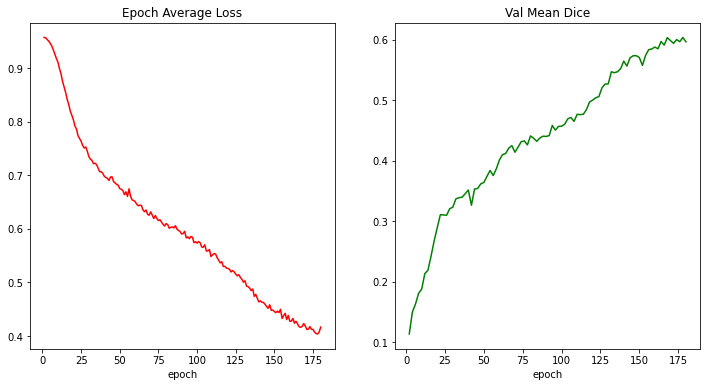

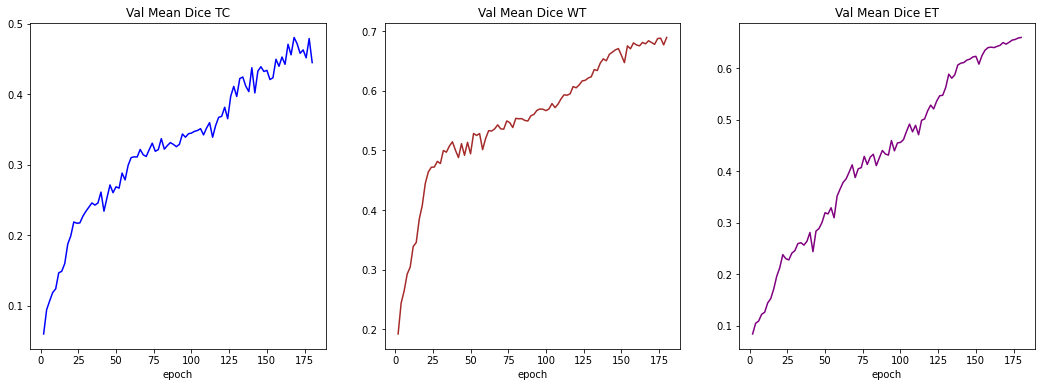

In [12]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y, color='red')
plt.subplot(1, 2, 2)
plt.title('Val Mean Dice')
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y, color='green')
plt.show()

plt.figure('train', (18, 6))
plt.subplot(1, 3, 1)
plt.title('Val Mean Dice TC')
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel('epoch')
plt.plot(x, y, color='blue')
plt.subplot(1, 3, 2)
plt.title('Val Mean Dice WT')
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel('epoch')
plt.plot(x, y, color='brown')
plt.subplot(1, 3, 3)
plt.title('Val Mean Dice ET')
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel('epoch')
plt.plot(x, y, color='purple')
plt.show()

## Check best model output with the input image and label

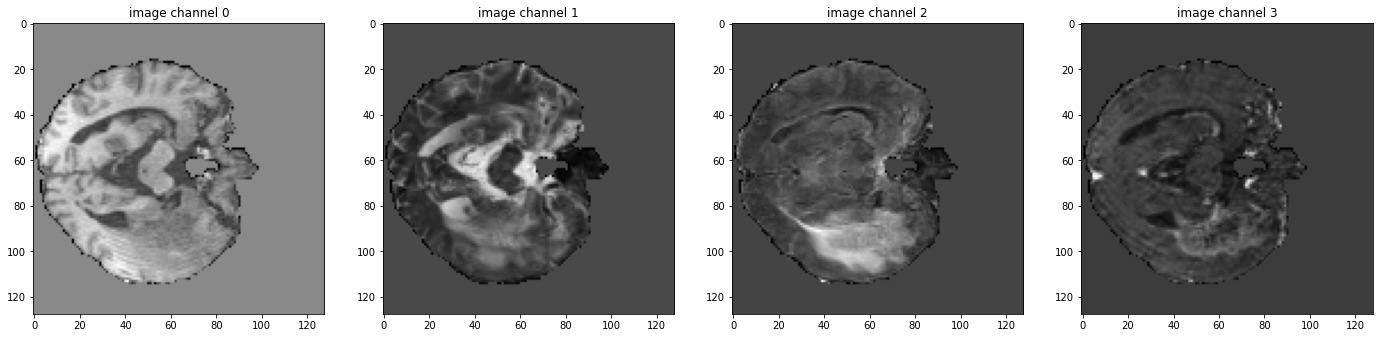

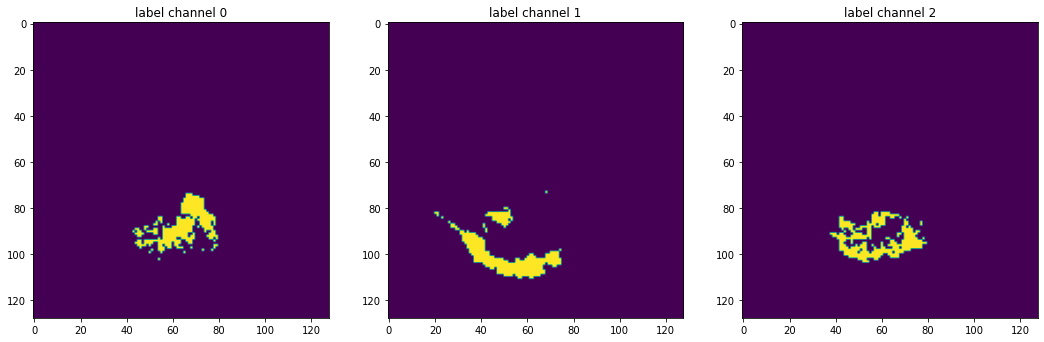

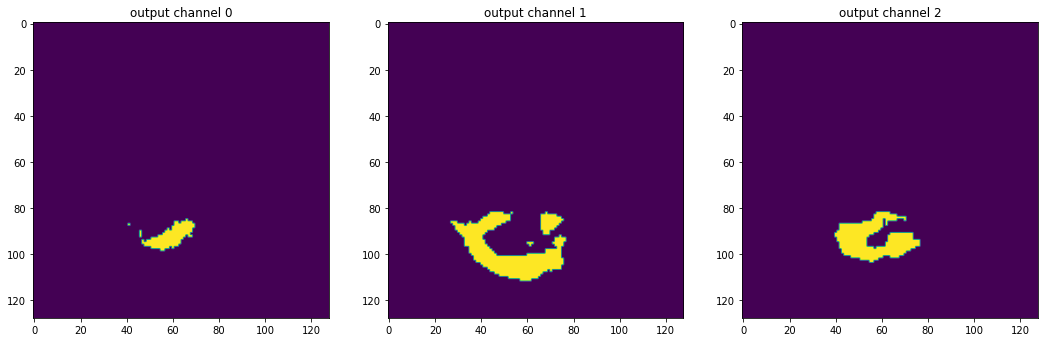

In [17]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[8]['image'].unsqueeze(0).to(device)
    val_output = model(val_input)
    plt.figure('image', (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {str(i)}")
        plt.imshow(val_ds[8]['image'][i, :, :, 20].detach().cpu(), cmap='gray')
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure('label', (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {str(i)}")
        plt.imshow(val_ds[8]['seg'][i, :, :, 20].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure('output', (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {str(i)}")
        plt.imshow((val_output[0, i, :, :, 20].sigmoid() >= 0.5).float().detach().cpu())
    plt.show()